# Miller age

In [1]:
ood_seed = 14

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Submucosal gland cells', '15.0'), 380)


Removed datapoint: 380

train         5516
validation    1509
ood            380
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 102593.07it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1064825.19it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 249.07it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:02<19:25,  2.92s/it]

Epoch 1/400:   0%|          | 1/400 [00:02<19:25,  2.92s/it, v_num=1, recon=1.19e+3, r2_mean=0.0665, adv_loss=3.48, acc_pert=0.3, acc_integration_donor=0.137]

Epoch 2/400:   0%|          | 1/400 [00:02<19:25,  2.92s/it, v_num=1, recon=1.19e+3, r2_mean=0.0665, adv_loss=3.48, acc_pert=0.3, acc_integration_donor=0.137]

Epoch 2/400:   0%|          | 2/400 [00:05<18:25,  2.78s/it, v_num=1, recon=1.19e+3, r2_mean=0.0665, adv_loss=3.48, acc_pert=0.3, acc_integration_donor=0.137]

Epoch 2/400:   0%|          | 2/400 [00:05<18:25,  2.78s/it, v_num=1, recon=1e+3, r2_mean=0.3, adv_loss=3.08, acc_pert=0.41, acc_integration_donor=0.3]       

Epoch 3/400:   0%|          | 2/400 [00:05<18:25,  2.78s/it, v_num=1, recon=1e+3, r2_mean=0.3, adv_loss=3.08, acc_pert=0.41, acc_integration_donor=0.3]

Epoch 3/400:   1%|          | 3/400 [00:08<17:49,  2.69s/it, v_num=1, recon=1e+3, r2_mean=0.3, adv_loss=3.08, acc_pert=0.41, acc_integration_donor=0.3]

Epoch 3/400:   1%|          | 3/400 [00:08<17:49,  2.69s/it, v_num=1, recon=934, r2_mean=0.391, adv_loss=2.69, acc_pert=0.504, acc_integration_donor=0.446]

Epoch 4/400:   1%|          | 3/400 [00:08<17:49,  2.69s/it, v_num=1, recon=934, r2_mean=0.391, adv_loss=2.69, acc_pert=0.504, acc_integration_donor=0.446]

Epoch 4/400:   1%|          | 4/400 [00:10<17:19,  2.63s/it, v_num=1, recon=934, r2_mean=0.391, adv_loss=2.69, acc_pert=0.504, acc_integration_donor=0.446]

Epoch 4/400:   1%|          | 4/400 [00:10<17:19,  2.63s/it, v_num=1, recon=897, r2_mean=0.441, adv_loss=2.48, acc_pert=0.532, acc_integration_donor=0.497]

Epoch 5/400:   1%|          | 4/400 [00:10<17:19,  2.63s/it, v_num=1, recon=897, r2_mean=0.441, adv_loss=2.48, acc_pert=0.532, acc_integration_donor=0.497]

Epoch 5/400:   1%|▏         | 5/400 [00:13<17:11,  2.61s/it, v_num=1, recon=897, r2_mean=0.441, adv_loss=2.48, acc_pert=0.532, acc_integration_donor=0.497]

Epoch 5/400:   1%|▏         | 5/400 [00:13<17:11,  2.61s/it, v_num=1, recon=880, r2_mean=0.465, adv_loss=2.35, acc_pert=0.549, acc_integration_donor=0.519]

Epoch 6/400:   1%|▏         | 5/400 [00:13<17:11,  2.61s/it, v_num=1, recon=880, r2_mean=0.465, adv_loss=2.35, acc_pert=0.549, acc_integration_donor=0.519]

Epoch 6/400:   2%|▏         | 6/400 [00:15<17:07,  2.61s/it, v_num=1, recon=880, r2_mean=0.465, adv_loss=2.35, acc_pert=0.549, acc_integration_donor=0.519]

Epoch 6/400:   2%|▏         | 6/400 [00:15<17:07,  2.61s/it, v_num=1, recon=865, r2_mean=0.479, adv_loss=2.29, acc_pert=0.548, acc_integration_donor=0.524]

Epoch 7/400:   2%|▏         | 6/400 [00:15<17:07,  2.61s/it, v_num=1, recon=865, r2_mean=0.479, adv_loss=2.29, acc_pert=0.548, acc_integration_donor=0.524]

Epoch 7/400:   2%|▏         | 7/400 [00:18<16:54,  2.58s/it, v_num=1, recon=865, r2_mean=0.479, adv_loss=2.29, acc_pert=0.548, acc_integration_donor=0.524]

Epoch 7/400:   2%|▏         | 7/400 [00:18<16:54,  2.58s/it, v_num=1, recon=852, r2_mean=0.483, adv_loss=2.25, acc_pert=0.565, acc_integration_donor=0.515]

Epoch 8/400:   2%|▏         | 7/400 [00:18<16:54,  2.58s/it, v_num=1, recon=852, r2_mean=0.483, adv_loss=2.25, acc_pert=0.565, acc_integration_donor=0.515]

Epoch 8/400:   2%|▏         | 8/400 [00:21<16:54,  2.59s/it, v_num=1, recon=852, r2_mean=0.483, adv_loss=2.25, acc_pert=0.565, acc_integration_donor=0.515]

Epoch 8/400:   2%|▏         | 8/400 [00:21<16:54,  2.59s/it, v_num=1, recon=847, r2_mean=0.493, adv_loss=2.22, acc_pert=0.555, acc_integration_donor=0.528]

Epoch 9/400:   2%|▏         | 8/400 [00:21<16:54,  2.59s/it, v_num=1, recon=847, r2_mean=0.493, adv_loss=2.22, acc_pert=0.555, acc_integration_donor=0.528]

Epoch 9/400:   2%|▏         | 9/400 [00:23<16:51,  2.59s/it, v_num=1, recon=847, r2_mean=0.493, adv_loss=2.22, acc_pert=0.555, acc_integration_donor=0.528]

Epoch 9/400:   2%|▏         | 9/400 [00:23<16:51,  2.59s/it, v_num=1, recon=842, r2_mean=0.495, adv_loss=2.23, acc_pert=0.539, acc_integration_donor=0.52] 

Epoch 10/400:   2%|▏         | 9/400 [00:23<16:51,  2.59s/it, v_num=1, recon=842, r2_mean=0.495, adv_loss=2.23, acc_pert=0.539, acc_integration_donor=0.52]


disnt_basal = 0.5453479040170754

disnt_after = 0.9549253350903463

val_r2_mean = 0.5249271206557751

val_r2_var = 0.21417794128259024


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:29<22:43,  3.50s/it, v_num=1, recon=842, r2_mean=0.495, adv_loss=2.23, acc_pert=0.539, acc_integration_donor=0.52]

Epoch 10/400:   2%|▎         | 10/400 [00:29<22:43,  3.50s/it, v_num=1, recon=843, r2_mean=0.498, adv_loss=2.19, acc_pert=0.537, acc_integration_donor=0.521, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:29<22:43,  3.50s/it, v_num=1, recon=843, r2_mean=0.498, adv_loss=2.19, acc_pert=0.537, acc_integration_donor=0.521, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:32<21:23,  3.30s/it, v_num=1, recon=843, r2_mean=0.498, adv_loss=2.19, acc_pert=0.537, acc_integration_donor=0.521, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:32<21:23,  3.30s/it, v_num=1, recon=836, r2_mean=0.509, adv_loss=2.24, acc_pert=0.529, acc_integration_donor=0.508, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:32<21:23,  3.30s/it, v_num=1, recon=836, r2_mean=0.509, adv_loss=2.24, acc_pert=0.529, acc_integration_donor=0.508, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:34<20:20,  3.14s/it, v_num=1, recon=836, r2_mean=0.509, adv_loss=2.24, acc_pert=0.529, acc_integration_donor=0.508, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:34<20:20,  3.14s/it, v_num=1, recon=842, r2_mean=0.508, adv_loss=2.22, acc_pert=0.527, acc_integration_donor=0.51, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [00:34<20:20,  3.14s/it, v_num=1, recon=842, r2_mean=0.508, adv_loss=2.22, acc_pert=0.527, acc_integration_donor=0.51, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:37<19:35,  3.04s/it, v_num=1, recon=842, r2_mean=0.508, adv_loss=2.22, acc_pert=0.527, acc_integration_donor=0.51, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:37<19:35,  3.04s/it, v_num=1, recon=828, r2_mean=0.512, adv_loss=2.22, acc_pert=0.531, acc_integration_donor=0.506, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:37<19:35,  3.04s/it, v_num=1, recon=828, r2_mean=0.512, adv_loss=2.22, acc_pert=0.531, acc_integration_donor=0.506, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:40<19:02,  2.96s/it, v_num=1, recon=828, r2_mean=0.512, adv_loss=2.22, acc_pert=0.531, acc_integration_donor=0.506, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:40<19:02,  2.96s/it, v_num=1, recon=836, r2_mean=0.516, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.508, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:40<19:02,  2.96s/it, v_num=1, recon=836, r2_mean=0.516, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.508, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:43<18:40,  2.91s/it, v_num=1, recon=836, r2_mean=0.516, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.508, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:43<18:40,  2.91s/it, v_num=1, recon=822, r2_mean=0.515, adv_loss=2.2, acc_pert=0.522, acc_integration_donor=0.513, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [00:43<18:40,  2.91s/it, v_num=1, recon=822, r2_mean=0.515, adv_loss=2.2, acc_pert=0.522, acc_integration_donor=0.513, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:46<18:53,  2.95s/it, v_num=1, recon=822, r2_mean=0.515, adv_loss=2.2, acc_pert=0.522, acc_integration_donor=0.513, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:46<18:53,  2.95s/it, v_num=1, recon=818, r2_mean=0.515, adv_loss=2.2, acc_pert=0.534, acc_integration_donor=0.504, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:46<18:53,  2.95s/it, v_num=1, recon=818, r2_mean=0.515, adv_loss=2.2, acc_pert=0.534, acc_integration_donor=0.504, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:49<18:35,  2.91s/it, v_num=1, recon=818, r2_mean=0.515, adv_loss=2.2, acc_pert=0.534, acc_integration_donor=0.504, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:49<18:35,  2.91s/it, v_num=1, recon=818, r2_mean=0.527, adv_loss=2.17, acc_pert=0.522, acc_integration_donor=0.511, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:49<18:35,  2.91s/it, v_num=1, recon=818, r2_mean=0.527, adv_loss=2.17, acc_pert=0.522, acc_integration_donor=0.511, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:51<18:16,  2.87s/it, v_num=1, recon=818, r2_mean=0.527, adv_loss=2.17, acc_pert=0.522, acc_integration_donor=0.511, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:51<18:16,  2.87s/it, v_num=1, recon=815, r2_mean=0.528, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.499, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [00:51<18:16,  2.87s/it, v_num=1, recon=815, r2_mean=0.528, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.499, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:54<17:59,  2.83s/it, v_num=1, recon=815, r2_mean=0.528, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.499, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:54<17:59,  2.83s/it, v_num=1, recon=816, r2_mean=0.528, adv_loss=2.2, acc_pert=0.527, acc_integration_donor=0.503, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:54<17:59,  2.83s/it, v_num=1, recon=816, r2_mean=0.528, adv_loss=2.2, acc_pert=0.527, acc_integration_donor=0.503, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]


disnt_basal = 0.5240254278523235

disnt_after = 0.9608645547307408

val_r2_mean = 0.5173539022604624

val_r2_var = 0.31004064219693345


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:00<24:02,  3.80s/it, v_num=1, recon=816, r2_mean=0.528, adv_loss=2.2, acc_pert=0.527, acc_integration_donor=0.503, val_recon=849, disnt_basal=0.545, disnt_after=0.955, val_r2_mean=0.525, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:00<24:02,  3.80s/it, v_num=1, recon=809, r2_mean=0.527, adv_loss=2.2, acc_pert=0.52, acc_integration_donor=0.503, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [01:00<24:02,  3.80s/it, v_num=1, recon=809, r2_mean=0.527, adv_loss=2.2, acc_pert=0.52, acc_integration_donor=0.503, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:03<22:01,  3.49s/it, v_num=1, recon=809, r2_mean=0.527, adv_loss=2.2, acc_pert=0.52, acc_integration_donor=0.503, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:03<22:01,  3.49s/it, v_num=1, recon=815, r2_mean=0.534, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.493, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:03<22:01,  3.49s/it, v_num=1, recon=815, r2_mean=0.534, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.493, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:06<20:45,  3.30s/it, v_num=1, recon=815, r2_mean=0.534, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.493, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:06<20:45,  3.30s/it, v_num=1, recon=810, r2_mean=0.532, adv_loss=2.2, acc_pert=0.525, acc_integration_donor=0.499, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [01:06<20:45,  3.30s/it, v_num=1, recon=810, r2_mean=0.532, adv_loss=2.2, acc_pert=0.525, acc_integration_donor=0.499, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:08<19:34,  3.11s/it, v_num=1, recon=810, r2_mean=0.532, adv_loss=2.2, acc_pert=0.525, acc_integration_donor=0.499, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:08<19:34,  3.11s/it, v_num=1, recon=806, r2_mean=0.539, adv_loss=2.23, acc_pert=0.528, acc_integration_donor=0.491, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:08<19:34,  3.11s/it, v_num=1, recon=806, r2_mean=0.539, adv_loss=2.23, acc_pert=0.528, acc_integration_donor=0.491, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:11<18:41,  2.98s/it, v_num=1, recon=806, r2_mean=0.539, adv_loss=2.23, acc_pert=0.528, acc_integration_donor=0.491, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:11<18:41,  2.98s/it, v_num=1, recon=802, r2_mean=0.539, adv_loss=2.26, acc_pert=0.521, acc_integration_donor=0.487, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:11<18:41,  2.98s/it, v_num=1, recon=802, r2_mean=0.539, adv_loss=2.26, acc_pert=0.521, acc_integration_donor=0.487, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:14<18:00,  2.88s/it, v_num=1, recon=802, r2_mean=0.539, adv_loss=2.26, acc_pert=0.521, acc_integration_donor=0.487, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:14<18:00,  2.88s/it, v_num=1, recon=803, r2_mean=0.541, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.493, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:14<18:00,  2.88s/it, v_num=1, recon=803, r2_mean=0.541, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.493, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:16<17:24,  2.79s/it, v_num=1, recon=803, r2_mean=0.541, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.493, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:16<17:24,  2.79s/it, v_num=1, recon=807, r2_mean=0.543, adv_loss=2.21, acc_pert=0.528, acc_integration_donor=0.498, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:16<17:24,  2.79s/it, v_num=1, recon=807, r2_mean=0.543, adv_loss=2.21, acc_pert=0.528, acc_integration_donor=0.498, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:19<17:03,  2.74s/it, v_num=1, recon=807, r2_mean=0.543, adv_loss=2.21, acc_pert=0.528, acc_integration_donor=0.498, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:19<17:03,  2.74s/it, v_num=1, recon=805, r2_mean=0.544, adv_loss=2.23, acc_pert=0.517, acc_integration_donor=0.495, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:19<17:03,  2.74s/it, v_num=1, recon=805, r2_mean=0.544, adv_loss=2.23, acc_pert=0.517, acc_integration_donor=0.495, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:22<16:41,  2.69s/it, v_num=1, recon=805, r2_mean=0.544, adv_loss=2.23, acc_pert=0.517, acc_integration_donor=0.495, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:22<16:41,  2.69s/it, v_num=1, recon=802, r2_mean=0.546, adv_loss=2.25, acc_pert=0.523, acc_integration_donor=0.497, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:22<16:41,  2.69s/it, v_num=1, recon=802, r2_mean=0.546, adv_loss=2.25, acc_pert=0.523, acc_integration_donor=0.497, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:24<16:25,  2.66s/it, v_num=1, recon=802, r2_mean=0.546, adv_loss=2.25, acc_pert=0.523, acc_integration_donor=0.497, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:24<16:25,  2.66s/it, v_num=1, recon=803, r2_mean=0.549, adv_loss=2.24, acc_pert=0.521, acc_integration_donor=0.497, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:24<16:25,  2.66s/it, v_num=1, recon=803, r2_mean=0.549, adv_loss=2.24, acc_pert=0.521, acc_integration_donor=0.497, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]


disnt_basal = 0.5152802429744675

disnt_after = 0.9524065359615412

val_r2_mean = 0.5222420984258255

val_r2_var = 0.35101488294700783


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:29<21:22,  3.47s/it, v_num=1, recon=803, r2_mean=0.549, adv_loss=2.24, acc_pert=0.521, acc_integration_donor=0.497, val_recon=826, disnt_basal=0.524, disnt_after=0.961, val_r2_mean=0.517, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:29<21:22,  3.47s/it, v_num=1, recon=796, r2_mean=0.547, adv_loss=2.23, acc_pert=0.526, acc_integration_donor=0.498, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:29<21:22,  3.47s/it, v_num=1, recon=796, r2_mean=0.547, adv_loss=2.23, acc_pert=0.526, acc_integration_donor=0.498, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:32<19:41,  3.20s/it, v_num=1, recon=796, r2_mean=0.547, adv_loss=2.23, acc_pert=0.526, acc_integration_donor=0.498, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:32<19:41,  3.20s/it, v_num=1, recon=797, r2_mean=0.548, adv_loss=2.26, acc_pert=0.518, acc_integration_donor=0.495, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:32<19:41,  3.20s/it, v_num=1, recon=797, r2_mean=0.548, adv_loss=2.26, acc_pert=0.518, acc_integration_donor=0.495, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:35<18:25,  3.00s/it, v_num=1, recon=797, r2_mean=0.548, adv_loss=2.26, acc_pert=0.518, acc_integration_donor=0.495, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:35<18:25,  3.00s/it, v_num=1, recon=795, r2_mean=0.547, adv_loss=2.27, acc_pert=0.51, acc_integration_donor=0.502, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [01:35<18:25,  3.00s/it, v_num=1, recon=795, r2_mean=0.547, adv_loss=2.27, acc_pert=0.51, acc_integration_donor=0.502, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:37<17:32,  2.87s/it, v_num=1, recon=795, r2_mean=0.547, adv_loss=2.27, acc_pert=0.51, acc_integration_donor=0.502, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:37<17:32,  2.87s/it, v_num=1, recon=797, r2_mean=0.55, adv_loss=2.28, acc_pert=0.51, acc_integration_donor=0.491, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [01:37<17:32,  2.87s/it, v_num=1, recon=797, r2_mean=0.55, adv_loss=2.28, acc_pert=0.51, acc_integration_donor=0.491, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:40<16:52,  2.77s/it, v_num=1, recon=797, r2_mean=0.55, adv_loss=2.28, acc_pert=0.51, acc_integration_donor=0.491, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:40<16:52,  2.77s/it, v_num=1, recon=789, r2_mean=0.55, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.5, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan] 

Epoch 35/400:   8%|▊         | 34/400 [01:40<16:52,  2.77s/it, v_num=1, recon=789, r2_mean=0.55, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.5, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:42<16:21,  2.69s/it, v_num=1, recon=789, r2_mean=0.55, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.5, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:42<16:21,  2.69s/it, v_num=1, recon=793, r2_mean=0.556, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.491, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [01:42<16:21,  2.69s/it, v_num=1, recon=793, r2_mean=0.556, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.491, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:45<15:55,  2.62s/it, v_num=1, recon=793, r2_mean=0.556, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.491, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:45<15:55,  2.62s/it, v_num=1, recon=788, r2_mean=0.556, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.499, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [01:45<15:55,  2.62s/it, v_num=1, recon=788, r2_mean=0.556, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.499, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:47<15:42,  2.60s/it, v_num=1, recon=788, r2_mean=0.556, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.499, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:47<15:42,  2.60s/it, v_num=1, recon=792, r2_mean=0.553, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.494, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan] 

Epoch 38/400:   9%|▉         | 37/400 [01:47<15:42,  2.60s/it, v_num=1, recon=792, r2_mean=0.553, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.494, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:50<15:31,  2.57s/it, v_num=1, recon=792, r2_mean=0.553, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.494, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:50<15:31,  2.57s/it, v_num=1, recon=793, r2_mean=0.552, adv_loss=2.28, acc_pert=0.52, acc_integration_donor=0.494, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [01:50<15:31,  2.57s/it, v_num=1, recon=793, r2_mean=0.552, adv_loss=2.28, acc_pert=0.52, acc_integration_donor=0.494, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:52<15:17,  2.54s/it, v_num=1, recon=793, r2_mean=0.552, adv_loss=2.28, acc_pert=0.52, acc_integration_donor=0.494, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:52<15:17,  2.54s/it, v_num=1, recon=788, r2_mean=0.556, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.483, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [01:52<15:17,  2.54s/it, v_num=1, recon=788, r2_mean=0.556, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.483, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]


disnt_basal = 0.49660476770210904

disnt_after = 0.9562111888888832

val_r2_mean = 0.5291778364529213

val_r2_var = 0.36073920999964076


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [01:58<20:38,  3.44s/it, v_num=1, recon=788, r2_mean=0.556, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.483, val_recon=818, disnt_basal=0.515, disnt_after=0.952, val_r2_mean=0.522, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [01:58<20:38,  3.44s/it, v_num=1, recon=788, r2_mean=0.554, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.492, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]  

Epoch 41/400:  10%|█         | 40/400 [01:58<20:38,  3.44s/it, v_num=1, recon=788, r2_mean=0.554, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.492, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:01<19:33,  3.27s/it, v_num=1, recon=788, r2_mean=0.554, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.492, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:01<19:33,  3.27s/it, v_num=1, recon=789, r2_mean=0.561, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.492, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [02:01<19:33,  3.27s/it, v_num=1, recon=789, r2_mean=0.561, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.492, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:03<18:49,  3.15s/it, v_num=1, recon=789, r2_mean=0.561, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.492, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:03<18:49,  3.15s/it, v_num=1, recon=786, r2_mean=0.561, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.497, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [02:03<18:49,  3.15s/it, v_num=1, recon=786, r2_mean=0.561, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.497, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:06<18:16,  3.07s/it, v_num=1, recon=786, r2_mean=0.561, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.497, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:06<18:16,  3.07s/it, v_num=1, recon=788, r2_mean=0.564, adv_loss=2.32, acc_pert=0.495, acc_integration_donor=0.488, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:06<18:16,  3.07s/it, v_num=1, recon=788, r2_mean=0.564, adv_loss=2.32, acc_pert=0.495, acc_integration_donor=0.488, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:09<18:00,  3.04s/it, v_num=1, recon=788, r2_mean=0.564, adv_loss=2.32, acc_pert=0.495, acc_integration_donor=0.488, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:09<18:00,  3.04s/it, v_num=1, recon=791, r2_mean=0.562, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.495, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:09<18:00,  3.04s/it, v_num=1, recon=791, r2_mean=0.562, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.495, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:12<17:34,  2.97s/it, v_num=1, recon=791, r2_mean=0.562, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.495, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:12<17:34,  2.97s/it, v_num=1, recon=780, r2_mean=0.563, adv_loss=2.32, acc_pert=0.491, acc_integration_donor=0.495, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:12<17:34,  2.97s/it, v_num=1, recon=780, r2_mean=0.563, adv_loss=2.32, acc_pert=0.491, acc_integration_donor=0.495, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:15<17:11,  2.91s/it, v_num=1, recon=780, r2_mean=0.563, adv_loss=2.32, acc_pert=0.491, acc_integration_donor=0.495, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:15<17:11,  2.91s/it, v_num=1, recon=780, r2_mean=0.566, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.493, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:15<17:11,  2.91s/it, v_num=1, recon=780, r2_mean=0.566, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.493, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:18<16:56,  2.88s/it, v_num=1, recon=780, r2_mean=0.566, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.493, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:18<16:56,  2.88s/it, v_num=1, recon=780, r2_mean=0.564, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.484, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:18<16:56,  2.88s/it, v_num=1, recon=780, r2_mean=0.564, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.484, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:20<16:47,  2.86s/it, v_num=1, recon=780, r2_mean=0.564, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.484, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:20<16:47,  2.86s/it, v_num=1, recon=777, r2_mean=0.563, adv_loss=2.35, acc_pert=0.485, acc_integration_donor=0.492, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:20<16:47,  2.86s/it, v_num=1, recon=777, r2_mean=0.563, adv_loss=2.35, acc_pert=0.485, acc_integration_donor=0.492, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:23<16:39,  2.85s/it, v_num=1, recon=777, r2_mean=0.563, adv_loss=2.35, acc_pert=0.485, acc_integration_donor=0.492, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:23<16:39,  2.85s/it, v_num=1, recon=777, r2_mean=0.561, adv_loss=2.37, acc_pert=0.482, acc_integration_donor=0.48, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [02:23<16:39,  2.85s/it, v_num=1, recon=777, r2_mean=0.561, adv_loss=2.37, acc_pert=0.482, acc_integration_donor=0.48, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]


disnt_basal = 0.48206773946139764

disnt_after = 0.9493365246577818

val_r2_mean = 0.5291242636740208

val_r2_var = 0.3776924864699443


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [02:29<22:01,  3.78s/it, v_num=1, recon=777, r2_mean=0.561, adv_loss=2.37, acc_pert=0.482, acc_integration_donor=0.48, val_recon=814, disnt_basal=0.497, disnt_after=0.956, val_r2_mean=0.529, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [02:29<22:01,  3.78s/it, v_num=1, recon=777, r2_mean=0.569, adv_loss=2.4, acc_pert=0.47, acc_integration_donor=0.485, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [02:29<22:01,  3.78s/it, v_num=1, recon=777, r2_mean=0.569, adv_loss=2.4, acc_pert=0.47, acc_integration_donor=0.485, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:32<20:07,  3.46s/it, v_num=1, recon=777, r2_mean=0.569, adv_loss=2.4, acc_pert=0.47, acc_integration_donor=0.485, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:32<20:07,  3.46s/it, v_num=1, recon=775, r2_mean=0.568, adv_loss=2.38, acc_pert=0.487, acc_integration_donor=0.487, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [02:32<20:07,  3.46s/it, v_num=1, recon=775, r2_mean=0.568, adv_loss=2.38, acc_pert=0.487, acc_integration_donor=0.487, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:35<18:45,  3.23s/it, v_num=1, recon=775, r2_mean=0.568, adv_loss=2.38, acc_pert=0.487, acc_integration_donor=0.487, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:35<18:45,  3.23s/it, v_num=1, recon=779, r2_mean=0.568, adv_loss=2.38, acc_pert=0.472, acc_integration_donor=0.491, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [02:35<18:45,  3.23s/it, v_num=1, recon=779, r2_mean=0.568, adv_loss=2.38, acc_pert=0.472, acc_integration_donor=0.491, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:38<18:25,  3.19s/it, v_num=1, recon=779, r2_mean=0.568, adv_loss=2.38, acc_pert=0.472, acc_integration_donor=0.491, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:38<18:25,  3.19s/it, v_num=1, recon=777, r2_mean=0.568, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.485, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [02:38<18:25,  3.19s/it, v_num=1, recon=777, r2_mean=0.568, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.485, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:41<18:09,  3.15s/it, v_num=1, recon=777, r2_mean=0.568, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.485, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:41<18:09,  3.15s/it, v_num=1, recon=772, r2_mean=0.568, adv_loss=2.41, acc_pert=0.471, acc_integration_donor=0.482, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [02:41<18:09,  3.15s/it, v_num=1, recon=772, r2_mean=0.568, adv_loss=2.41, acc_pert=0.471, acc_integration_donor=0.482, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:44<17:26,  3.03s/it, v_num=1, recon=772, r2_mean=0.568, adv_loss=2.41, acc_pert=0.471, acc_integration_donor=0.482, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:44<17:26,  3.03s/it, v_num=1, recon=765, r2_mean=0.57, adv_loss=2.38, acc_pert=0.478, acc_integration_donor=0.487, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan] 

Epoch 56/400:  14%|█▍        | 55/400 [02:44<17:26,  3.03s/it, v_num=1, recon=765, r2_mean=0.57, adv_loss=2.38, acc_pert=0.478, acc_integration_donor=0.487, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:46<16:50,  2.94s/it, v_num=1, recon=765, r2_mean=0.57, adv_loss=2.38, acc_pert=0.478, acc_integration_donor=0.487, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:46<16:50,  2.94s/it, v_num=1, recon=771, r2_mean=0.57, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.482, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [02:46<16:50,  2.94s/it, v_num=1, recon=771, r2_mean=0.57, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.482, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:49<16:27,  2.88s/it, v_num=1, recon=771, r2_mean=0.57, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.482, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:49<16:27,  2.88s/it, v_num=1, recon=777, r2_mean=0.575, adv_loss=2.4, acc_pert=0.473, acc_integration_donor=0.483, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [02:49<16:27,  2.88s/it, v_num=1, recon=777, r2_mean=0.575, adv_loss=2.4, acc_pert=0.473, acc_integration_donor=0.483, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:52<16:56,  2.97s/it, v_num=1, recon=777, r2_mean=0.575, adv_loss=2.4, acc_pert=0.473, acc_integration_donor=0.483, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:52<16:56,  2.97s/it, v_num=1, recon=770, r2_mean=0.573, adv_loss=2.42, acc_pert=0.467, acc_integration_donor=0.486, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [02:52<16:56,  2.97s/it, v_num=1, recon=770, r2_mean=0.573, adv_loss=2.42, acc_pert=0.467, acc_integration_donor=0.486, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:55<16:40,  2.93s/it, v_num=1, recon=770, r2_mean=0.573, adv_loss=2.42, acc_pert=0.467, acc_integration_donor=0.486, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:55<16:40,  2.93s/it, v_num=1, recon=775, r2_mean=0.571, adv_loss=2.41, acc_pert=0.489, acc_integration_donor=0.484, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [02:55<16:40,  2.93s/it, v_num=1, recon=775, r2_mean=0.571, adv_loss=2.41, acc_pert=0.489, acc_integration_donor=0.484, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]


disnt_basal = 0.4731042516772371

disnt_after = 0.9667173378883073

val_r2_mean = 0.5290183816105127

val_r2_var = 0.3956194184720516


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [03:02<24:13,  4.28s/it, v_num=1, recon=775, r2_mean=0.571, adv_loss=2.41, acc_pert=0.489, acc_integration_donor=0.484, val_recon=814, disnt_basal=0.482, disnt_after=0.949, val_r2_mean=0.529, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:02<24:13,  4.28s/it, v_num=1, recon=769, r2_mean=0.58, adv_loss=2.42, acc_pert=0.465, acc_integration_donor=0.496, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [03:02<24:13,  4.28s/it, v_num=1, recon=769, r2_mean=0.58, adv_loss=2.42, acc_pert=0.465, acc_integration_donor=0.496, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:05<21:13,  3.76s/it, v_num=1, recon=769, r2_mean=0.58, adv_loss=2.42, acc_pert=0.465, acc_integration_donor=0.496, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:05<21:13,  3.76s/it, v_num=1, recon=768, r2_mean=0.58, adv_loss=2.42, acc_pert=0.468, acc_integration_donor=0.481, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:05<21:13,  3.76s/it, v_num=1, recon=768, r2_mean=0.58, adv_loss=2.42, acc_pert=0.468, acc_integration_donor=0.481, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:08<19:14,  3.41s/it, v_num=1, recon=768, r2_mean=0.58, adv_loss=2.42, acc_pert=0.468, acc_integration_donor=0.481, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:08<19:14,  3.41s/it, v_num=1, recon=767, r2_mean=0.574, adv_loss=2.41, acc_pert=0.464, acc_integration_donor=0.488, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:08<19:14,  3.41s/it, v_num=1, recon=767, r2_mean=0.574, adv_loss=2.41, acc_pert=0.464, acc_integration_donor=0.488, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:10<17:47,  3.17s/it, v_num=1, recon=767, r2_mean=0.574, adv_loss=2.41, acc_pert=0.464, acc_integration_donor=0.488, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:10<17:47,  3.17s/it, v_num=1, recon=762, r2_mean=0.573, adv_loss=2.43, acc_pert=0.472, acc_integration_donor=0.488, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:10<17:47,  3.17s/it, v_num=1, recon=762, r2_mean=0.573, adv_loss=2.43, acc_pert=0.472, acc_integration_donor=0.488, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:13<16:51,  3.01s/it, v_num=1, recon=762, r2_mean=0.573, adv_loss=2.43, acc_pert=0.472, acc_integration_donor=0.488, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:13<16:51,  3.01s/it, v_num=1, recon=766, r2_mean=0.579, adv_loss=2.41, acc_pert=0.466, acc_integration_donor=0.485, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:13<16:51,  3.01s/it, v_num=1, recon=766, r2_mean=0.579, adv_loss=2.41, acc_pert=0.466, acc_integration_donor=0.485, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:15<16:02,  2.87s/it, v_num=1, recon=766, r2_mean=0.579, adv_loss=2.41, acc_pert=0.466, acc_integration_donor=0.485, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:15<16:02,  2.87s/it, v_num=1, recon=765, r2_mean=0.581, adv_loss=2.41, acc_pert=0.462, acc_integration_donor=0.495, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [03:15<16:02,  2.87s/it, v_num=1, recon=765, r2_mean=0.581, adv_loss=2.41, acc_pert=0.462, acc_integration_donor=0.495, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:18<15:44,  2.83s/it, v_num=1, recon=765, r2_mean=0.581, adv_loss=2.41, acc_pert=0.462, acc_integration_donor=0.495, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:18<15:44,  2.83s/it, v_num=1, recon=760, r2_mean=0.577, adv_loss=2.43, acc_pert=0.464, acc_integration_donor=0.493, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:18<15:44,  2.83s/it, v_num=1, recon=760, r2_mean=0.577, adv_loss=2.43, acc_pert=0.464, acc_integration_donor=0.493, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:21<15:20,  2.76s/it, v_num=1, recon=760, r2_mean=0.577, adv_loss=2.43, acc_pert=0.464, acc_integration_donor=0.493, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:21<15:20,  2.76s/it, v_num=1, recon=762, r2_mean=0.58, adv_loss=2.42, acc_pert=0.462, acc_integration_donor=0.501, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan] 

Epoch 68/400:  17%|█▋        | 67/400 [03:21<15:20,  2.76s/it, v_num=1, recon=762, r2_mean=0.58, adv_loss=2.42, acc_pert=0.462, acc_integration_donor=0.501, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:23<14:56,  2.70s/it, v_num=1, recon=762, r2_mean=0.58, adv_loss=2.42, acc_pert=0.462, acc_integration_donor=0.501, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:23<14:56,  2.70s/it, v_num=1, recon=762, r2_mean=0.578, adv_loss=2.43, acc_pert=0.472, acc_integration_donor=0.49, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [03:23<14:56,  2.70s/it, v_num=1, recon=762, r2_mean=0.578, adv_loss=2.43, acc_pert=0.472, acc_integration_donor=0.49, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:26<14:40,  2.66s/it, v_num=1, recon=762, r2_mean=0.578, adv_loss=2.43, acc_pert=0.472, acc_integration_donor=0.49, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:26<14:40,  2.66s/it, v_num=1, recon=756, r2_mean=0.578, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.49, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]  

Epoch 70/400:  17%|█▋        | 69/400 [03:26<14:40,  2.66s/it, v_num=1, recon=756, r2_mean=0.578, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.49, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]


disnt_basal = 0.4674636331632458

disnt_after = 0.9634783095207754

val_r2_mean = 0.5169590276976427

val_r2_var = 0.401637339964509

Epoch 70/400:  18%|█▊        | 70/400 [03:31<19:16,  3.50s/it, v_num=1, recon=756, r2_mean=0.578, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.49, val_recon=812, disnt_basal=0.473, disnt_after=0.967, val_r2_mean=0.529, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [03:31<19:16,  3.50s/it, v_num=1, recon=756, r2_mean=0.58, adv_loss=2.42, acc_pert=0.474, acc_integration_donor=0.481, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [03:31<19:16,  3.50s/it, v_num=1, recon=756, r2_mean=0.58, adv_loss=2.42, acc_pert=0.474, acc_integration_donor=0.481, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [03:34<17:44,  3.23s/it, v_num=1, recon=756, r2_mean=0.58, adv_loss=2.42, acc_pert=0.474, acc_integration_donor=0.481, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [03:34<17:44,  3.23s/it, v_num=1, recon=758, r2_mean=0.577, adv_loss=2.43, acc_pert=0.483, acc_integration_donor=0.472, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [03:34<17:44,  3.23s/it, v_num=1, recon=758, r2_mean=0.577, adv_loss=2.43, acc_pert=0.483, acc_integration_donor=0.472, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [03:37<16:33,  3.03s/it, v_num=1, recon=758, r2_mean=0.577, adv_loss=2.43, acc_pert=0.483, acc_integration_donor=0.472, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [03:37<16:33,  3.03s/it, v_num=1, recon=756, r2_mean=0.579, adv_loss=2.43, acc_pert=0.47, acc_integration_donor=0.479, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [03:37<16:33,  3.03s/it, v_num=1, recon=756, r2_mean=0.579, adv_loss=2.43, acc_pert=0.47, acc_integration_donor=0.479, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [03:39<16:14,  2.98s/it, v_num=1, recon=756, r2_mean=0.579, adv_loss=2.43, acc_pert=0.47, acc_integration_donor=0.479, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [03:39<16:14,  2.98s/it, v_num=1, recon=757, r2_mean=0.582, adv_loss=2.44, acc_pert=0.477, acc_integration_donor=0.486, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [03:39<16:14,  2.98s/it, v_num=1, recon=757, r2_mean=0.582, adv_loss=2.44, acc_pert=0.477, acc_integration_donor=0.486, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [03:42<15:33,  2.86s/it, v_num=1, recon=757, r2_mean=0.582, adv_loss=2.44, acc_pert=0.477, acc_integration_donor=0.486, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [03:42<15:33,  2.86s/it, v_num=1, recon=758, r2_mean=0.58, adv_loss=2.42, acc_pert=0.465, acc_integration_donor=0.489, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan] 

Epoch 75/400:  18%|█▊        | 74/400 [03:42<15:33,  2.86s/it, v_num=1, recon=758, r2_mean=0.58, adv_loss=2.42, acc_pert=0.465, acc_integration_donor=0.489, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [03:45<15:04,  2.78s/it, v_num=1, recon=758, r2_mean=0.58, adv_loss=2.42, acc_pert=0.465, acc_integration_donor=0.489, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [03:45<15:04,  2.78s/it, v_num=1, recon=753, r2_mean=0.587, adv_loss=2.45, acc_pert=0.455, acc_integration_donor=0.48, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [03:45<15:04,  2.78s/it, v_num=1, recon=753, r2_mean=0.587, adv_loss=2.45, acc_pert=0.455, acc_integration_donor=0.48, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [03:47<14:44,  2.73s/it, v_num=1, recon=753, r2_mean=0.587, adv_loss=2.45, acc_pert=0.455, acc_integration_donor=0.48, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [03:47<14:44,  2.73s/it, v_num=1, recon=751, r2_mean=0.584, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.491, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [03:47<14:44,  2.73s/it, v_num=1, recon=751, r2_mean=0.584, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.491, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [03:50<14:37,  2.72s/it, v_num=1, recon=751, r2_mean=0.584, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.491, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [03:50<14:37,  2.72s/it, v_num=1, recon=755, r2_mean=0.582, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.478, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [03:50<14:37,  2.72s/it, v_num=1, recon=755, r2_mean=0.582, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.478, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [03:52<14:22,  2.68s/it, v_num=1, recon=755, r2_mean=0.582, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.478, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [03:52<14:22,  2.68s/it, v_num=1, recon=749, r2_mean=0.58, adv_loss=2.43, acc_pert=0.465, acc_integration_donor=0.482, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan] 

Epoch 79/400:  20%|█▉        | 78/400 [03:52<14:22,  2.68s/it, v_num=1, recon=749, r2_mean=0.58, adv_loss=2.43, acc_pert=0.465, acc_integration_donor=0.482, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [03:55<14:13,  2.66s/it, v_num=1, recon=749, r2_mean=0.58, adv_loss=2.43, acc_pert=0.465, acc_integration_donor=0.482, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [03:55<14:13,  2.66s/it, v_num=1, recon=755, r2_mean=0.591, adv_loss=2.44, acc_pert=0.461, acc_integration_donor=0.482, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [03:55<14:13,  2.66s/it, v_num=1, recon=755, r2_mean=0.591, adv_loss=2.44, acc_pert=0.461, acc_integration_donor=0.482, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]


disnt_basal = 0.4664610453498677

disnt_after = 0.9656333062302699

val_r2_mean = 0.5205080136656761

val_r2_var = 0.3998120501637459


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [04:00<17:21,  3.25s/it, v_num=1, recon=755, r2_mean=0.591, adv_loss=2.44, acc_pert=0.461, acc_integration_donor=0.482, val_recon=813, disnt_basal=0.467, disnt_after=0.963, val_r2_mean=0.517, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:00<17:21,  3.25s/it, v_num=1, recon=747, r2_mean=0.588, adv_loss=2.42, acc_pert=0.466, acc_integration_donor=0.479, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [04:00<17:21,  3.25s/it, v_num=1, recon=747, r2_mean=0.588, adv_loss=2.42, acc_pert=0.466, acc_integration_donor=0.479, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:02<16:05,  3.03s/it, v_num=1, recon=747, r2_mean=0.588, adv_loss=2.42, acc_pert=0.466, acc_integration_donor=0.479, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:02<16:05,  3.03s/it, v_num=1, recon=751, r2_mean=0.586, adv_loss=2.42, acc_pert=0.468, acc_integration_donor=0.48, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [04:02<16:05,  3.03s/it, v_num=1, recon=751, r2_mean=0.586, adv_loss=2.42, acc_pert=0.468, acc_integration_donor=0.48, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:05<15:22,  2.90s/it, v_num=1, recon=751, r2_mean=0.586, adv_loss=2.42, acc_pert=0.468, acc_integration_donor=0.48, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:05<15:22,  2.90s/it, v_num=1, recon=748, r2_mean=0.584, adv_loss=2.43, acc_pert=0.473, acc_integration_donor=0.484, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [04:05<15:22,  2.90s/it, v_num=1, recon=748, r2_mean=0.584, adv_loss=2.43, acc_pert=0.473, acc_integration_donor=0.484, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:07<14:38,  2.77s/it, v_num=1, recon=748, r2_mean=0.584, adv_loss=2.43, acc_pert=0.473, acc_integration_donor=0.484, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:07<14:38,  2.77s/it, v_num=1, recon=746, r2_mean=0.586, adv_loss=2.47, acc_pert=0.462, acc_integration_donor=0.474, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [04:07<14:38,  2.77s/it, v_num=1, recon=746, r2_mean=0.586, adv_loss=2.47, acc_pert=0.462, acc_integration_donor=0.474, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:10<14:17,  2.71s/it, v_num=1, recon=746, r2_mean=0.586, adv_loss=2.47, acc_pert=0.462, acc_integration_donor=0.474, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:10<14:17,  2.71s/it, v_num=1, recon=752, r2_mean=0.59, adv_loss=2.43, acc_pert=0.469, acc_integration_donor=0.483, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan] 

Epoch 85/400:  21%|██        | 84/400 [04:10<14:17,  2.71s/it, v_num=1, recon=752, r2_mean=0.59, adv_loss=2.43, acc_pert=0.469, acc_integration_donor=0.483, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:12<14:08,  2.70s/it, v_num=1, recon=752, r2_mean=0.59, adv_loss=2.43, acc_pert=0.469, acc_integration_donor=0.483, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:12<14:08,  2.70s/it, v_num=1, recon=747, r2_mean=0.59, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.468, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [04:12<14:08,  2.70s/it, v_num=1, recon=747, r2_mean=0.59, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.468, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:15<13:57,  2.67s/it, v_num=1, recon=747, r2_mean=0.59, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.468, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:15<13:57,  2.67s/it, v_num=1, recon=748, r2_mean=0.59, adv_loss=2.46, acc_pert=0.458, acc_integration_donor=0.471, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [04:15<13:57,  2.67s/it, v_num=1, recon=748, r2_mean=0.59, adv_loss=2.46, acc_pert=0.458, acc_integration_donor=0.471, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:18<13:53,  2.66s/it, v_num=1, recon=748, r2_mean=0.59, adv_loss=2.46, acc_pert=0.458, acc_integration_donor=0.471, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:18<13:53,  2.66s/it, v_num=1, recon=741, r2_mean=0.588, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.469, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [04:18<13:53,  2.66s/it, v_num=1, recon=741, r2_mean=0.588, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.469, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:20<13:38,  2.62s/it, v_num=1, recon=741, r2_mean=0.588, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.469, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:20<13:38,  2.62s/it, v_num=1, recon=745, r2_mean=0.59, adv_loss=2.46, acc_pert=0.447, acc_integration_donor=0.474, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan] 

Epoch 89/400:  22%|██▏       | 88/400 [04:20<13:38,  2.62s/it, v_num=1, recon=745, r2_mean=0.59, adv_loss=2.46, acc_pert=0.447, acc_integration_donor=0.474, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:23<13:36,  2.62s/it, v_num=1, recon=745, r2_mean=0.59, adv_loss=2.46, acc_pert=0.447, acc_integration_donor=0.474, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:23<13:36,  2.62s/it, v_num=1, recon=746, r2_mean=0.594, adv_loss=2.46, acc_pert=0.462, acc_integration_donor=0.48, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [04:23<13:36,  2.62s/it, v_num=1, recon=746, r2_mean=0.594, adv_loss=2.46, acc_pert=0.462, acc_integration_donor=0.48, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]


disnt_basal = 0.4599831617854892

disnt_after = 0.9567205564482949

val_r2_mean = 0.5249492283910513

val_r2_var = 0.40880403605600196


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [04:28<17:52,  3.46s/it, v_num=1, recon=746, r2_mean=0.594, adv_loss=2.46, acc_pert=0.462, acc_integration_donor=0.48, val_recon=812, disnt_basal=0.466, disnt_after=0.966, val_r2_mean=0.521, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [04:28<17:52,  3.46s/it, v_num=1, recon=746, r2_mean=0.591, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.463, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [04:28<17:52,  3.46s/it, v_num=1, recon=746, r2_mean=0.591, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.463, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [04:31<16:29,  3.20s/it, v_num=1, recon=746, r2_mean=0.591, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.463, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [04:31<16:29,  3.20s/it, v_num=1, recon=742, r2_mean=0.595, adv_loss=2.47, acc_pert=0.475, acc_integration_donor=0.479, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [04:31<16:29,  3.20s/it, v_num=1, recon=742, r2_mean=0.595, adv_loss=2.47, acc_pert=0.475, acc_integration_donor=0.479, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [04:34<15:30,  3.02s/it, v_num=1, recon=742, r2_mean=0.595, adv_loss=2.47, acc_pert=0.475, acc_integration_donor=0.479, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [04:34<15:30,  3.02s/it, v_num=1, recon=744, r2_mean=0.593, adv_loss=2.45, acc_pert=0.459, acc_integration_donor=0.478, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [04:34<15:30,  3.02s/it, v_num=1, recon=744, r2_mean=0.593, adv_loss=2.45, acc_pert=0.459, acc_integration_donor=0.478, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [04:36<14:56,  2.92s/it, v_num=1, recon=744, r2_mean=0.593, adv_loss=2.45, acc_pert=0.459, acc_integration_donor=0.478, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [04:36<14:56,  2.92s/it, v_num=1, recon=740, r2_mean=0.59, adv_loss=2.43, acc_pert=0.471, acc_integration_donor=0.474, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [04:36<14:56,  2.92s/it, v_num=1, recon=740, r2_mean=0.59, adv_loss=2.43, acc_pert=0.471, acc_integration_donor=0.474, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [04:39<14:24,  2.82s/it, v_num=1, recon=740, r2_mean=0.59, adv_loss=2.43, acc_pert=0.471, acc_integration_donor=0.474, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [04:39<14:24,  2.82s/it, v_num=1, recon=737, r2_mean=0.595, adv_loss=2.44, acc_pert=0.474, acc_integration_donor=0.474, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [04:39<14:24,  2.82s/it, v_num=1, recon=737, r2_mean=0.595, adv_loss=2.44, acc_pert=0.474, acc_integration_donor=0.474, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [04:41<14:00,  2.76s/it, v_num=1, recon=737, r2_mean=0.595, adv_loss=2.44, acc_pert=0.474, acc_integration_donor=0.474, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [04:41<14:00,  2.76s/it, v_num=1, recon=739, r2_mean=0.587, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.477, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [04:41<14:00,  2.76s/it, v_num=1, recon=739, r2_mean=0.587, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.477, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [04:44<13:47,  2.72s/it, v_num=1, recon=739, r2_mean=0.587, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.477, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [04:44<13:47,  2.72s/it, v_num=1, recon=735, r2_mean=0.594, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.474, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [04:44<13:47,  2.72s/it, v_num=1, recon=735, r2_mean=0.594, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.474, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [04:47<13:23,  2.65s/it, v_num=1, recon=735, r2_mean=0.594, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.474, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [04:47<13:23,  2.65s/it, v_num=1, recon=740, r2_mean=0.596, adv_loss=2.44, acc_pert=0.46, acc_integration_donor=0.488, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan] 

Epoch 98/400:  24%|██▍       | 97/400 [04:47<13:23,  2.65s/it, v_num=1, recon=740, r2_mean=0.596, adv_loss=2.44, acc_pert=0.46, acc_integration_donor=0.488, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [04:49<13:17,  2.64s/it, v_num=1, recon=740, r2_mean=0.596, adv_loss=2.44, acc_pert=0.46, acc_integration_donor=0.488, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [04:49<13:17,  2.64s/it, v_num=1, recon=741, r2_mean=0.598, adv_loss=2.47, acc_pert=0.462, acc_integration_donor=0.478, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [04:49<13:17,  2.64s/it, v_num=1, recon=741, r2_mean=0.598, adv_loss=2.47, acc_pert=0.462, acc_integration_donor=0.478, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [04:52<13:17,  2.65s/it, v_num=1, recon=741, r2_mean=0.598, adv_loss=2.47, acc_pert=0.462, acc_integration_donor=0.478, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [04:52<13:17,  2.65s/it, v_num=1, recon=734, r2_mean=0.594, adv_loss=2.47, acc_pert=0.472, acc_integration_donor=0.467, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [04:52<13:17,  2.65s/it, v_num=1, recon=734, r2_mean=0.594, adv_loss=2.47, acc_pert=0.472, acc_integration_donor=0.467, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]


disnt_basal = 0.45741257466523244

disnt_after = 0.9545237424513565

val_r2_mean = 0.5111973912765583

val_r2_var = 0.40650715803106624

Epoch 100/400:  25%|██▌       | 100/400 [04:58<18:23,  3.68s/it, v_num=1, recon=734, r2_mean=0.594, adv_loss=2.47, acc_pert=0.472, acc_integration_donor=0.467, val_recon=817, disnt_basal=0.46, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [04:58<18:23,  3.68s/it, v_num=1, recon=730, r2_mean=0.598, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.472, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [04:58<18:23,  3.68s/it, v_num=1, recon=730, r2_mean=0.598, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.472, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:01<17:00,  3.41s/it, v_num=1, recon=730, r2_mean=0.598, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.472, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:01<17:00,  3.41s/it, v_num=1, recon=734, r2_mean=0.594, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.471, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [05:01<17:00,  3.41s/it, v_num=1, recon=734, r2_mean=0.594, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.471, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:03<16:03,  3.23s/it, v_num=1, recon=734, r2_mean=0.594, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.471, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:03<16:03,  3.23s/it, v_num=1, recon=733, r2_mean=0.596, adv_loss=2.49, acc_pert=0.465, acc_integration_donor=0.464, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [05:04<16:03,  3.23s/it, v_num=1, recon=733, r2_mean=0.596, adv_loss=2.49, acc_pert=0.465, acc_integration_donor=0.464, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:06<15:22,  3.11s/it, v_num=1, recon=733, r2_mean=0.596, adv_loss=2.49, acc_pert=0.465, acc_integration_donor=0.464, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:06<15:22,  3.11s/it, v_num=1, recon=731, r2_mean=0.599, adv_loss=2.48, acc_pert=0.467, acc_integration_donor=0.477, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [05:06<15:22,  3.11s/it, v_num=1, recon=731, r2_mean=0.599, adv_loss=2.48, acc_pert=0.467, acc_integration_donor=0.477, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:09<15:08,  3.07s/it, v_num=1, recon=731, r2_mean=0.599, adv_loss=2.48, acc_pert=0.467, acc_integration_donor=0.477, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:09<15:08,  3.07s/it, v_num=1, recon=730, r2_mean=0.601, adv_loss=2.47, acc_pert=0.467, acc_integration_donor=0.478, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [05:09<15:08,  3.07s/it, v_num=1, recon=730, r2_mean=0.601, adv_loss=2.47, acc_pert=0.467, acc_integration_donor=0.478, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:12<14:36,  2.97s/it, v_num=1, recon=730, r2_mean=0.601, adv_loss=2.47, acc_pert=0.467, acc_integration_donor=0.478, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:12<14:36,  2.97s/it, v_num=1, recon=729, r2_mean=0.599, adv_loss=2.48, acc_pert=0.46, acc_integration_donor=0.474, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan] 

Epoch 106/400:  26%|██▋       | 105/400 [05:12<14:36,  2.97s/it, v_num=1, recon=729, r2_mean=0.599, adv_loss=2.48, acc_pert=0.46, acc_integration_donor=0.474, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [05:15<14:20,  2.93s/it, v_num=1, recon=729, r2_mean=0.599, adv_loss=2.48, acc_pert=0.46, acc_integration_donor=0.474, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [05:15<14:20,  2.93s/it, v_num=1, recon=726, r2_mean=0.602, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.483, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [05:15<14:20,  2.93s/it, v_num=1, recon=726, r2_mean=0.602, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.483, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [05:18<14:02,  2.88s/it, v_num=1, recon=726, r2_mean=0.602, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.483, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [05:18<14:02,  2.88s/it, v_num=1, recon=727, r2_mean=0.602, adv_loss=2.47, acc_pert=0.461, acc_integration_donor=0.47, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [05:18<14:02,  2.88s/it, v_num=1, recon=727, r2_mean=0.602, adv_loss=2.47, acc_pert=0.461, acc_integration_donor=0.47, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [05:21<14:28,  2.98s/it, v_num=1, recon=727, r2_mean=0.602, adv_loss=2.47, acc_pert=0.461, acc_integration_donor=0.47, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [05:21<14:28,  2.98s/it, v_num=1, recon=731, r2_mean=0.603, adv_loss=2.47, acc_pert=0.477, acc_integration_donor=0.471, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [05:21<14:28,  2.98s/it, v_num=1, recon=731, r2_mean=0.603, adv_loss=2.47, acc_pert=0.477, acc_integration_donor=0.471, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [05:24<14:15,  2.94s/it, v_num=1, recon=731, r2_mean=0.603, adv_loss=2.47, acc_pert=0.477, acc_integration_donor=0.471, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [05:24<14:15,  2.94s/it, v_num=1, recon=725, r2_mean=0.608, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.477, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [05:24<14:15,  2.94s/it, v_num=1, recon=725, r2_mean=0.608, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.477, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]


disnt_basal = 0.4562820052170002

disnt_after = 0.9433588163538458

val_r2_mean = 0.5108899318923553

val_r2_var = 0.40522511055072147

Epoch 110/400:  28%|██▊       | 110/400 [05:31<20:01,  4.14s/it, v_num=1, recon=725, r2_mean=0.608, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.477, val_recon=818, disnt_basal=0.457, disnt_after=0.955, val_r2_mean=0.511, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [05:31<20:01,  4.14s/it, v_num=1, recon=726, r2_mean=0.604, adv_loss=2.47, acc_pert=0.47, acc_integration_donor=0.469, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [05:31<20:01,  4.14s/it, v_num=1, recon=726, r2_mean=0.604, adv_loss=2.47, acc_pert=0.47, acc_integration_donor=0.469, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [05:34<18:48,  3.91s/it, v_num=1, recon=726, r2_mean=0.604, adv_loss=2.47, acc_pert=0.47, acc_integration_donor=0.469, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [05:34<18:48,  3.91s/it, v_num=1, recon=726, r2_mean=0.605, adv_loss=2.46, acc_pert=0.465, acc_integration_donor=0.479, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [05:34<18:48,  3.91s/it, v_num=1, recon=726, r2_mean=0.605, adv_loss=2.46, acc_pert=0.465, acc_integration_donor=0.479, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [05:37<17:35,  3.67s/it, v_num=1, recon=726, r2_mean=0.605, adv_loss=2.46, acc_pert=0.465, acc_integration_donor=0.479, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [05:37<17:35,  3.67s/it, v_num=1, recon=727, r2_mean=0.603, adv_loss=2.46, acc_pert=0.465, acc_integration_donor=0.482, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [05:37<17:35,  3.67s/it, v_num=1, recon=727, r2_mean=0.603, adv_loss=2.46, acc_pert=0.465, acc_integration_donor=0.482, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [05:40<16:31,  3.46s/it, v_num=1, recon=727, r2_mean=0.603, adv_loss=2.46, acc_pert=0.465, acc_integration_donor=0.482, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [05:40<16:31,  3.46s/it, v_num=1, recon=721, r2_mean=0.603, adv_loss=2.49, acc_pert=0.468, acc_integration_donor=0.465, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [05:40<16:31,  3.46s/it, v_num=1, recon=721, r2_mean=0.603, adv_loss=2.49, acc_pert=0.468, acc_integration_donor=0.465, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [05:43<15:55,  3.34s/it, v_num=1, recon=721, r2_mean=0.603, adv_loss=2.49, acc_pert=0.468, acc_integration_donor=0.465, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [05:43<15:55,  3.34s/it, v_num=1, recon=729, r2_mean=0.604, adv_loss=2.47, acc_pert=0.47, acc_integration_donor=0.476, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan] 

Epoch 115/400:  28%|██▊       | 114/400 [05:43<15:55,  3.34s/it, v_num=1, recon=729, r2_mean=0.604, adv_loss=2.47, acc_pert=0.47, acc_integration_donor=0.476, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [05:46<15:27,  3.25s/it, v_num=1, recon=729, r2_mean=0.604, adv_loss=2.47, acc_pert=0.47, acc_integration_donor=0.476, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [05:46<15:27,  3.25s/it, v_num=1, recon=722, r2_mean=0.609, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.473, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [05:46<15:27,  3.25s/it, v_num=1, recon=722, r2_mean=0.609, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.473, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [05:49<15:06,  3.19s/it, v_num=1, recon=722, r2_mean=0.609, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.473, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [05:49<15:06,  3.19s/it, v_num=1, recon=720, r2_mean=0.606, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.474, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [05:49<15:06,  3.19s/it, v_num=1, recon=720, r2_mean=0.606, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.474, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [05:52<14:45,  3.13s/it, v_num=1, recon=720, r2_mean=0.606, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.474, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [05:52<14:45,  3.13s/it, v_num=1, recon=720, r2_mean=0.603, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.475, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [05:52<14:45,  3.13s/it, v_num=1, recon=720, r2_mean=0.603, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.475, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [05:55<14:28,  3.08s/it, v_num=1, recon=720, r2_mean=0.603, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.475, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [05:55<14:28,  3.08s/it, v_num=1, recon=718, r2_mean=0.606, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.478, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [05:55<14:28,  3.08s/it, v_num=1, recon=718, r2_mean=0.606, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.478, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [05:58<14:20,  3.06s/it, v_num=1, recon=718, r2_mean=0.606, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.478, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [05:58<14:20,  3.06s/it, v_num=1, recon=718, r2_mean=0.604, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.479, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [05:58<14:20,  3.06s/it, v_num=1, recon=718, r2_mean=0.604, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.479, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]


disnt_basal = 0.44724924587932074

disnt_after = 0.9479510432945776

val_r2_mean = 0.5179203792164723

val_r2_var = 0.4093777760863304

Epoch 120/400:  30%|███       | 120/400 [06:04<17:45,  3.81s/it, v_num=1, recon=718, r2_mean=0.604, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.479, val_recon=821, disnt_basal=0.456, disnt_after=0.943, val_r2_mean=0.511, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [06:04<17:45,  3.81s/it, v_num=1, recon=720, r2_mean=0.607, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.478, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [06:04<17:45,  3.81s/it, v_num=1, recon=720, r2_mean=0.607, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.478, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [06:06<16:13,  3.49s/it, v_num=1, recon=720, r2_mean=0.607, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.478, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [06:06<16:13,  3.49s/it, v_num=1, recon=718, r2_mean=0.608, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [06:06<16:13,  3.49s/it, v_num=1, recon=718, r2_mean=0.608, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [06:09<15:16,  3.30s/it, v_num=1, recon=718, r2_mean=0.608, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [06:09<15:16,  3.30s/it, v_num=1, recon=718, r2_mean=0.609, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.472, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [06:09<15:16,  3.30s/it, v_num=1, recon=718, r2_mean=0.609, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.472, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [06:12<14:45,  3.20s/it, v_num=1, recon=718, r2_mean=0.609, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.472, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [06:12<14:45,  3.20s/it, v_num=1, recon=716, r2_mean=0.607, adv_loss=2.51, acc_pert=0.467, acc_integration_donor=0.466, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [06:12<14:45,  3.20s/it, v_num=1, recon=716, r2_mean=0.607, adv_loss=2.51, acc_pert=0.467, acc_integration_donor=0.466, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [06:15<14:10,  3.08s/it, v_num=1, recon=716, r2_mean=0.607, adv_loss=2.51, acc_pert=0.467, acc_integration_donor=0.466, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [06:15<14:10,  3.08s/it, v_num=1, recon=716, r2_mean=0.609, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.47, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan] 

Epoch 125/400:  31%|███       | 124/400 [06:15<14:10,  3.08s/it, v_num=1, recon=716, r2_mean=0.609, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.47, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [06:18<13:48,  3.01s/it, v_num=1, recon=716, r2_mean=0.609, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.47, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [06:18<13:48,  3.01s/it, v_num=1, recon=713, r2_mean=0.605, adv_loss=2.48, acc_pert=0.46, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [06:18<13:48,  3.01s/it, v_num=1, recon=713, r2_mean=0.605, adv_loss=2.48, acc_pert=0.46, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [06:21<13:26,  2.94s/it, v_num=1, recon=713, r2_mean=0.605, adv_loss=2.48, acc_pert=0.46, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [06:21<13:26,  2.94s/it, v_num=1, recon=717, r2_mean=0.613, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.477, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [06:21<13:26,  2.94s/it, v_num=1, recon=717, r2_mean=0.613, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.477, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [06:24<13:16,  2.92s/it, v_num=1, recon=717, r2_mean=0.613, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.477, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [06:24<13:16,  2.92s/it, v_num=1, recon=717, r2_mean=0.611, adv_loss=2.48, acc_pert=0.468, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [06:24<13:16,  2.92s/it, v_num=1, recon=717, r2_mean=0.611, adv_loss=2.48, acc_pert=0.468, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [06:27<13:20,  2.94s/it, v_num=1, recon=717, r2_mean=0.611, adv_loss=2.48, acc_pert=0.468, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [06:27<13:20,  2.94s/it, v_num=1, recon=718, r2_mean=0.609, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.475, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [06:27<13:20,  2.94s/it, v_num=1, recon=718, r2_mean=0.609, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.475, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [06:29<13:02,  2.89s/it, v_num=1, recon=718, r2_mean=0.609, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.475, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [06:29<13:02,  2.89s/it, v_num=1, recon=714, r2_mean=0.614, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.468, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [06:29<13:02,  2.89s/it, v_num=1, recon=714, r2_mean=0.614, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.468, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.4453166351780819

disnt_after = 0.9458372574635794

val_r2_mean = 0.51321966573596

val_r2_var = 0.4079185879478852

Epoch 130/400:  32%|███▎      | 130/400 [06:34<15:27,  3.44s/it, v_num=1, recon=714, r2_mean=0.614, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.468, val_recon=823, disnt_basal=0.447, disnt_after=0.948, val_r2_mean=0.518, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [06:34<15:27,  3.44s/it, v_num=1, recon=715, r2_mean=0.612, adv_loss=2.47, acc_pert=0.467, acc_integration_donor=0.472, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [06:34<15:27,  3.44s/it, v_num=1, recon=715, r2_mean=0.612, adv_loss=2.47, acc_pert=0.467, acc_integration_donor=0.472, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [06:37<14:33,  3.25s/it, v_num=1, recon=715, r2_mean=0.612, adv_loss=2.47, acc_pert=0.467, acc_integration_donor=0.472, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [06:37<14:33,  3.25s/it, v_num=1, recon=710, r2_mean=0.611, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.469, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [06:37<14:33,  3.25s/it, v_num=1, recon=710, r2_mean=0.611, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.469, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [06:40<13:46,  3.08s/it, v_num=1, recon=710, r2_mean=0.611, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.469, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [06:40<13:46,  3.08s/it, v_num=1, recon=712, r2_mean=0.611, adv_loss=2.46, acc_pert=0.461, acc_integration_donor=0.473, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [06:40<13:46,  3.08s/it, v_num=1, recon=712, r2_mean=0.611, adv_loss=2.46, acc_pert=0.461, acc_integration_donor=0.473, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [06:42<13:15,  2.98s/it, v_num=1, recon=712, r2_mean=0.611, adv_loss=2.46, acc_pert=0.461, acc_integration_donor=0.473, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [06:42<13:15,  2.98s/it, v_num=1, recon=707, r2_mean=0.609, adv_loss=2.49, acc_pert=0.47, acc_integration_donor=0.473, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [06:42<13:15,  2.98s/it, v_num=1, recon=707, r2_mean=0.609, adv_loss=2.49, acc_pert=0.47, acc_integration_donor=0.473, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [06:45<12:52,  2.91s/it, v_num=1, recon=707, r2_mean=0.609, adv_loss=2.49, acc_pert=0.47, acc_integration_donor=0.473, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [06:45<12:52,  2.91s/it, v_num=1, recon=706, r2_mean=0.609, adv_loss=2.47, acc_pert=0.48, acc_integration_donor=0.468, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [06:45<12:52,  2.91s/it, v_num=1, recon=706, r2_mean=0.609, adv_loss=2.47, acc_pert=0.48, acc_integration_donor=0.468, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [06:48<12:34,  2.85s/it, v_num=1, recon=706, r2_mean=0.609, adv_loss=2.47, acc_pert=0.48, acc_integration_donor=0.468, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [06:48<12:34,  2.85s/it, v_num=1, recon=710, r2_mean=0.614, adv_loss=2.47, acc_pert=0.48, acc_integration_donor=0.479, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [06:48<12:34,  2.85s/it, v_num=1, recon=710, r2_mean=0.614, adv_loss=2.47, acc_pert=0.48, acc_integration_donor=0.479, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [06:51<12:25,  2.82s/it, v_num=1, recon=710, r2_mean=0.614, adv_loss=2.47, acc_pert=0.48, acc_integration_donor=0.479, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [06:51<12:25,  2.82s/it, v_num=1, recon=709, r2_mean=0.615, adv_loss=2.48, acc_pert=0.46, acc_integration_donor=0.471, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [06:51<12:25,  2.82s/it, v_num=1, recon=709, r2_mean=0.615, adv_loss=2.48, acc_pert=0.46, acc_integration_donor=0.471, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [06:53<12:19,  2.81s/it, v_num=1, recon=709, r2_mean=0.615, adv_loss=2.48, acc_pert=0.46, acc_integration_donor=0.471, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [06:53<12:19,  2.81s/it, v_num=1, recon=702, r2_mean=0.616, adv_loss=2.49, acc_pert=0.48, acc_integration_donor=0.467, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [06:53<12:19,  2.81s/it, v_num=1, recon=702, r2_mean=0.616, adv_loss=2.49, acc_pert=0.48, acc_integration_donor=0.467, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [06:56<12:23,  2.84s/it, v_num=1, recon=702, r2_mean=0.616, adv_loss=2.49, acc_pert=0.48, acc_integration_donor=0.467, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [06:56<12:23,  2.84s/it, v_num=1, recon=705, r2_mean=0.611, adv_loss=2.48, acc_pert=0.477, acc_integration_donor=0.468, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [06:56<12:23,  2.84s/it, v_num=1, recon=705, r2_mean=0.611, adv_loss=2.48, acc_pert=0.477, acc_integration_donor=0.468, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [06:59<12:17,  2.83s/it, v_num=1, recon=705, r2_mean=0.611, adv_loss=2.48, acc_pert=0.477, acc_integration_donor=0.468, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [06:59<12:17,  2.83s/it, v_num=1, recon=707, r2_mean=0.614, adv_loss=2.48, acc_pert=0.459, acc_integration_donor=0.474, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [06:59<12:17,  2.83s/it, v_num=1, recon=707, r2_mean=0.614, adv_loss=2.48, acc_pert=0.459, acc_integration_donor=0.474, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]


disnt_basal = 0.4400145977261592

disnt_after = 0.9464383874203123

val_r2_mean = 0.5128670136133829

val_r2_var = 0.41081603554387885


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [07:04<15:34,  3.59s/it, v_num=1, recon=707, r2_mean=0.614, adv_loss=2.48, acc_pert=0.459, acc_integration_donor=0.474, val_recon=827, disnt_basal=0.445, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [07:04<15:34,  3.59s/it, v_num=1, recon=703, r2_mean=0.619, adv_loss=2.47, acc_pert=0.467, acc_integration_donor=0.475, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan] 

Epoch 141/400:  35%|███▌      | 140/400 [07:04<15:34,  3.59s/it, v_num=1, recon=703, r2_mean=0.619, adv_loss=2.47, acc_pert=0.467, acc_integration_donor=0.475, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [07:07<14:21,  3.33s/it, v_num=1, recon=703, r2_mean=0.619, adv_loss=2.47, acc_pert=0.467, acc_integration_donor=0.475, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [07:07<14:21,  3.33s/it, v_num=1, recon=702, r2_mean=0.617, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.465, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [07:07<14:21,  3.33s/it, v_num=1, recon=702, r2_mean=0.617, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.465, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [07:10<13:30,  3.14s/it, v_num=1, recon=702, r2_mean=0.617, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.465, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [07:10<13:30,  3.14s/it, v_num=1, recon=702, r2_mean=0.614, adv_loss=2.49, acc_pert=0.463, acc_integration_donor=0.474, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [07:10<13:30,  3.14s/it, v_num=1, recon=702, r2_mean=0.614, adv_loss=2.49, acc_pert=0.463, acc_integration_donor=0.474, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [07:13<12:55,  3.02s/it, v_num=1, recon=702, r2_mean=0.614, adv_loss=2.49, acc_pert=0.463, acc_integration_donor=0.474, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [07:13<12:55,  3.02s/it, v_num=1, recon=703, r2_mean=0.613, adv_loss=2.48, acc_pert=0.471, acc_integration_donor=0.471, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [07:13<12:55,  3.02s/it, v_num=1, recon=703, r2_mean=0.613, adv_loss=2.48, acc_pert=0.471, acc_integration_donor=0.471, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [07:15<12:26,  2.92s/it, v_num=1, recon=703, r2_mean=0.613, adv_loss=2.48, acc_pert=0.471, acc_integration_donor=0.471, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [07:15<12:26,  2.92s/it, v_num=1, recon=702, r2_mean=0.622, adv_loss=2.5, acc_pert=0.463, acc_integration_donor=0.467, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan] 

Epoch 145/400:  36%|███▌      | 144/400 [07:15<12:26,  2.92s/it, v_num=1, recon=702, r2_mean=0.622, adv_loss=2.5, acc_pert=0.463, acc_integration_donor=0.467, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [07:18<12:10,  2.86s/it, v_num=1, recon=702, r2_mean=0.622, adv_loss=2.5, acc_pert=0.463, acc_integration_donor=0.467, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [07:18<12:10,  2.86s/it, v_num=1, recon=702, r2_mean=0.618, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.479, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [07:18<12:10,  2.86s/it, v_num=1, recon=702, r2_mean=0.618, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.479, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [07:21<11:52,  2.81s/it, v_num=1, recon=702, r2_mean=0.618, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.479, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [07:21<11:52,  2.81s/it, v_num=1, recon=701, r2_mean=0.62, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.474, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [07:21<11:52,  2.81s/it, v_num=1, recon=701, r2_mean=0.62, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.474, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [07:23<11:37,  2.76s/it, v_num=1, recon=701, r2_mean=0.62, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.474, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [07:23<11:37,  2.76s/it, v_num=1, recon=704, r2_mean=0.619, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.473, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [07:23<11:37,  2.76s/it, v_num=1, recon=704, r2_mean=0.619, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.473, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [07:27<12:17,  2.92s/it, v_num=1, recon=704, r2_mean=0.619, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.473, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [07:27<12:17,  2.92s/it, v_num=1, recon=700, r2_mean=0.618, adv_loss=2.49, acc_pert=0.464, acc_integration_donor=0.466, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [07:27<12:17,  2.92s/it, v_num=1, recon=700, r2_mean=0.618, adv_loss=2.49, acc_pert=0.464, acc_integration_donor=0.466, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [07:29<11:58,  2.86s/it, v_num=1, recon=700, r2_mean=0.618, adv_loss=2.49, acc_pert=0.464, acc_integration_donor=0.466, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [07:29<11:58,  2.86s/it, v_num=1, recon=697, r2_mean=0.617, adv_loss=2.51, acc_pert=0.472, acc_integration_donor=0.476, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [07:29<11:58,  2.86s/it, v_num=1, recon=697, r2_mean=0.617, adv_loss=2.51, acc_pert=0.472, acc_integration_donor=0.476, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]


disnt_basal = 0.4453715630933232

disnt_after = 0.9548714052308916

val_r2_mean = 0.5064429442087809

val_r2_var = 0.4160303949777569


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [07:35<15:29,  3.72s/it, v_num=1, recon=697, r2_mean=0.617, adv_loss=2.51, acc_pert=0.472, acc_integration_donor=0.476, val_recon=828, disnt_basal=0.44, disnt_after=0.946, val_r2_mean=0.513, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [07:35<15:29,  3.72s/it, v_num=1, recon=698, r2_mean=0.617, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.466, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [07:35<15:29,  3.72s/it, v_num=1, recon=698, r2_mean=0.617, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.466, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [07:38<14:12,  3.42s/it, v_num=1, recon=698, r2_mean=0.617, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.466, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [07:38<14:12,  3.42s/it, v_num=1, recon=697, r2_mean=0.62, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.472, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [07:38<14:12,  3.42s/it, v_num=1, recon=697, r2_mean=0.62, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.472, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [07:40<13:16,  3.21s/it, v_num=1, recon=697, r2_mean=0.62, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.472, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [07:40<13:16,  3.21s/it, v_num=1, recon=698, r2_mean=0.619, adv_loss=2.47, acc_pert=0.479, acc_integration_donor=0.469, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [07:40<13:16,  3.21s/it, v_num=1, recon=698, r2_mean=0.619, adv_loss=2.47, acc_pert=0.479, acc_integration_donor=0.469, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [07:43<12:43,  3.09s/it, v_num=1, recon=698, r2_mean=0.619, adv_loss=2.47, acc_pert=0.479, acc_integration_donor=0.469, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [07:43<12:43,  3.09s/it, v_num=1, recon=697, r2_mean=0.622, adv_loss=2.46, acc_pert=0.46, acc_integration_donor=0.475, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [07:43<12:43,  3.09s/it, v_num=1, recon=697, r2_mean=0.622, adv_loss=2.46, acc_pert=0.46, acc_integration_donor=0.475, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [07:46<12:01,  2.93s/it, v_num=1, recon=697, r2_mean=0.622, adv_loss=2.46, acc_pert=0.46, acc_integration_donor=0.475, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [07:46<12:01,  2.93s/it, v_num=1, recon=701, r2_mean=0.623, adv_loss=2.49, acc_pert=0.469, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [07:46<12:01,  2.93s/it, v_num=1, recon=701, r2_mean=0.623, adv_loss=2.49, acc_pert=0.469, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [07:49<11:41,  2.86s/it, v_num=1, recon=701, r2_mean=0.623, adv_loss=2.49, acc_pert=0.469, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [07:49<11:41,  2.86s/it, v_num=1, recon=698, r2_mean=0.623, adv_loss=2.46, acc_pert=0.486, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [07:49<11:41,  2.86s/it, v_num=1, recon=698, r2_mean=0.623, adv_loss=2.46, acc_pert=0.486, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [07:51<11:22,  2.80s/it, v_num=1, recon=698, r2_mean=0.623, adv_loss=2.46, acc_pert=0.486, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [07:51<11:22,  2.80s/it, v_num=1, recon=699, r2_mean=0.62, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [07:51<11:22,  2.80s/it, v_num=1, recon=699, r2_mean=0.62, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [07:54<11:12,  2.77s/it, v_num=1, recon=699, r2_mean=0.62, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [07:54<11:12,  2.77s/it, v_num=1, recon=693, r2_mean=0.621, adv_loss=2.45, acc_pert=0.474, acc_integration_donor=0.475, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [07:54<11:12,  2.77s/it, v_num=1, recon=693, r2_mean=0.621, adv_loss=2.45, acc_pert=0.474, acc_integration_donor=0.475, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [07:57<11:01,  2.73s/it, v_num=1, recon=693, r2_mean=0.621, adv_loss=2.45, acc_pert=0.474, acc_integration_donor=0.475, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [07:57<11:01,  2.73s/it, v_num=1, recon=693, r2_mean=0.626, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.476, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [07:57<11:01,  2.73s/it, v_num=1, recon=693, r2_mean=0.626, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.476, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [07:59<10:55,  2.72s/it, v_num=1, recon=693, r2_mean=0.626, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.476, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [07:59<10:55,  2.72s/it, v_num=1, recon=690, r2_mean=0.625, adv_loss=2.45, acc_pert=0.464, acc_integration_donor=0.48, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [07:59<10:55,  2.72s/it, v_num=1, recon=690, r2_mean=0.625, adv_loss=2.45, acc_pert=0.464, acc_integration_donor=0.48, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.4461310343210734

disnt_after = 0.9562182770492654

val_r2_mean = 0.5115900828192631

val_r2_var = 0.41118834105630714


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [08:04<13:09,  3.29s/it, v_num=1, recon=690, r2_mean=0.625, adv_loss=2.45, acc_pert=0.464, acc_integration_donor=0.48, val_recon=831, disnt_basal=0.445, disnt_after=0.955, val_r2_mean=0.506, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [08:04<13:09,  3.29s/it, v_num=1, recon=691, r2_mean=0.627, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.475, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [08:04<13:09,  3.29s/it, v_num=1, recon=691, r2_mean=0.627, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.475, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [08:06<12:15,  3.08s/it, v_num=1, recon=691, r2_mean=0.627, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.475, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [08:06<12:15,  3.08s/it, v_num=1, recon=690, r2_mean=0.625, adv_loss=2.45, acc_pert=0.48, acc_integration_donor=0.479, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [08:06<12:15,  3.08s/it, v_num=1, recon=690, r2_mean=0.625, adv_loss=2.45, acc_pert=0.48, acc_integration_donor=0.479, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [08:09<11:33,  2.91s/it, v_num=1, recon=690, r2_mean=0.625, adv_loss=2.45, acc_pert=0.48, acc_integration_donor=0.479, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [08:09<11:33,  2.91s/it, v_num=1, recon=688, r2_mean=0.63, adv_loss=2.51, acc_pert=0.466, acc_integration_donor=0.474, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [08:09<11:33,  2.91s/it, v_num=1, recon=688, r2_mean=0.63, adv_loss=2.51, acc_pert=0.466, acc_integration_donor=0.474, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [08:11<11:02,  2.79s/it, v_num=1, recon=688, r2_mean=0.63, adv_loss=2.51, acc_pert=0.466, acc_integration_donor=0.474, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [08:11<11:02,  2.79s/it, v_num=1, recon=687, r2_mean=0.626, adv_loss=2.49, acc_pert=0.469, acc_integration_donor=0.471, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [08:11<11:02,  2.79s/it, v_num=1, recon=687, r2_mean=0.626, adv_loss=2.49, acc_pert=0.469, acc_integration_donor=0.471, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [08:14<10:43,  2.73s/it, v_num=1, recon=687, r2_mean=0.626, adv_loss=2.49, acc_pert=0.469, acc_integration_donor=0.471, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [08:14<10:43,  2.73s/it, v_num=1, recon=690, r2_mean=0.626, adv_loss=2.45, acc_pert=0.472, acc_integration_donor=0.474, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [08:14<10:43,  2.73s/it, v_num=1, recon=690, r2_mean=0.626, adv_loss=2.45, acc_pert=0.472, acc_integration_donor=0.474, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [08:17<10:25,  2.66s/it, v_num=1, recon=690, r2_mean=0.626, adv_loss=2.45, acc_pert=0.472, acc_integration_donor=0.474, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [08:17<10:25,  2.66s/it, v_num=1, recon=692, r2_mean=0.624, adv_loss=2.47, acc_pert=0.469, acc_integration_donor=0.479, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [08:17<10:25,  2.66s/it, v_num=1, recon=692, r2_mean=0.624, adv_loss=2.47, acc_pert=0.469, acc_integration_donor=0.479, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [08:19<10:15,  2.63s/it, v_num=1, recon=692, r2_mean=0.624, adv_loss=2.47, acc_pert=0.469, acc_integration_donor=0.479, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [08:19<10:15,  2.63s/it, v_num=1, recon=687, r2_mean=0.624, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.472, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [08:19<10:15,  2.63s/it, v_num=1, recon=687, r2_mean=0.624, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.472, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [08:22<10:05,  2.60s/it, v_num=1, recon=687, r2_mean=0.624, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.472, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [08:22<10:05,  2.60s/it, v_num=1, recon=686, r2_mean=0.624, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.476, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [08:22<10:05,  2.60s/it, v_num=1, recon=686, r2_mean=0.624, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.476, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [08:24<09:55,  2.57s/it, v_num=1, recon=686, r2_mean=0.624, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.476, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [08:24<09:55,  2.57s/it, v_num=1, recon=686, r2_mean=0.624, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.48, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan] 

Epoch 169/400:  42%|████▏     | 168/400 [08:24<09:55,  2.57s/it, v_num=1, recon=686, r2_mean=0.624, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.48, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [08:27<09:53,  2.57s/it, v_num=1, recon=686, r2_mean=0.624, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.48, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [08:27<09:53,  2.57s/it, v_num=1, recon=685, r2_mean=0.626, adv_loss=2.49, acc_pert=0.475, acc_integration_donor=0.47, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [08:27<09:53,  2.57s/it, v_num=1, recon=685, r2_mean=0.626, adv_loss=2.49, acc_pert=0.475, acc_integration_donor=0.47, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]


disnt_basal = 0.4507392234626102

disnt_after = 0.9533536869347907

val_r2_mean = 0.498111334318916

val_r2_var = 0.4091856225083272

Epoch 170/400:  42%|████▎     | 170/400 [08:31<12:01,  3.14s/it, v_num=1, recon=685, r2_mean=0.626, adv_loss=2.49, acc_pert=0.475, acc_integration_donor=0.47, val_recon=833, disnt_basal=0.446, disnt_after=0.956, val_r2_mean=0.512, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [08:31<12:01,  3.14s/it, v_num=1, recon=686, r2_mean=0.626, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.471, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [08:31<12:01,  3.14s/it, v_num=1, recon=686, r2_mean=0.626, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.471, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [08:34<11:13,  2.94s/it, v_num=1, recon=686, r2_mean=0.626, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.471, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [08:34<11:13,  2.94s/it, v_num=1, recon=685, r2_mean=0.629, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.479, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [08:34<11:13,  2.94s/it, v_num=1, recon=685, r2_mean=0.629, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.479, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [08:36<10:40,  2.81s/it, v_num=1, recon=685, r2_mean=0.629, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.479, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [08:36<10:40,  2.81s/it, v_num=1, recon=686, r2_mean=0.633, adv_loss=2.46, acc_pert=0.475, acc_integration_donor=0.468, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [08:36<10:40,  2.81s/it, v_num=1, recon=686, r2_mean=0.633, adv_loss=2.46, acc_pert=0.475, acc_integration_donor=0.468, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [08:39<10:21,  2.74s/it, v_num=1, recon=686, r2_mean=0.633, adv_loss=2.46, acc_pert=0.475, acc_integration_donor=0.468, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [08:39<10:21,  2.74s/it, v_num=1, recon=686, r2_mean=0.625, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.476, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [08:39<10:21,  2.74s/it, v_num=1, recon=686, r2_mean=0.625, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.476, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [08:41<10:03,  2.67s/it, v_num=1, recon=686, r2_mean=0.625, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.476, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [08:41<10:03,  2.67s/it, v_num=1, recon=687, r2_mean=0.634, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.477, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [08:41<10:03,  2.67s/it, v_num=1, recon=687, r2_mean=0.634, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.477, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [08:44<09:53,  2.64s/it, v_num=1, recon=687, r2_mean=0.634, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.477, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [08:44<09:53,  2.64s/it, v_num=1, recon=686, r2_mean=0.63, adv_loss=2.47, acc_pert=0.461, acc_integration_donor=0.473, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan] 

Epoch 176/400:  44%|████▍     | 175/400 [08:44<09:53,  2.64s/it, v_num=1, recon=686, r2_mean=0.63, adv_loss=2.47, acc_pert=0.461, acc_integration_donor=0.473, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [08:46<09:40,  2.59s/it, v_num=1, recon=686, r2_mean=0.63, adv_loss=2.47, acc_pert=0.461, acc_integration_donor=0.473, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [08:46<09:40,  2.59s/it, v_num=1, recon=682, r2_mean=0.628, adv_loss=2.46, acc_pert=0.468, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [08:46<09:40,  2.59s/it, v_num=1, recon=682, r2_mean=0.628, adv_loss=2.46, acc_pert=0.468, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [08:49<09:36,  2.59s/it, v_num=1, recon=682, r2_mean=0.628, adv_loss=2.46, acc_pert=0.468, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [08:49<09:36,  2.59s/it, v_num=1, recon=678, r2_mean=0.628, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.476, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [08:49<09:36,  2.59s/it, v_num=1, recon=678, r2_mean=0.628, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.476, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [08:51<09:32,  2.58s/it, v_num=1, recon=678, r2_mean=0.628, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.476, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [08:51<09:32,  2.58s/it, v_num=1, recon=683, r2_mean=0.628, adv_loss=2.47, acc_pert=0.474, acc_integration_donor=0.478, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [08:51<09:32,  2.58s/it, v_num=1, recon=683, r2_mean=0.628, adv_loss=2.47, acc_pert=0.474, acc_integration_donor=0.478, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [08:54<09:23,  2.55s/it, v_num=1, recon=683, r2_mean=0.628, adv_loss=2.47, acc_pert=0.474, acc_integration_donor=0.478, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [08:54<09:23,  2.55s/it, v_num=1, recon=681, r2_mean=0.63, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.478, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan] 

Epoch 180/400:  45%|████▍     | 179/400 [08:54<09:23,  2.55s/it, v_num=1, recon=681, r2_mean=0.63, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.478, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]


disnt_basal = 0.43931106502424294

disnt_after = 0.9537462573567538

val_r2_mean = 0.4935571023573478

val_r2_var = 0.40131457708775997

Epoch 180/400:  45%|████▌     | 180/400 [09:01<13:49,  3.77s/it, v_num=1, recon=681, r2_mean=0.63, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.478, val_recon=838, disnt_basal=0.451, disnt_after=0.953, val_r2_mean=0.498, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [09:01<13:49,  3.77s/it, v_num=1, recon=682, r2_mean=0.631, adv_loss=2.49, acc_pert=0.469, acc_integration_donor=0.478, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [09:01<13:49,  3.77s/it, v_num=1, recon=682, r2_mean=0.631, adv_loss=2.49, acc_pert=0.469, acc_integration_donor=0.478, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [09:04<12:53,  3.53s/it, v_num=1, recon=682, r2_mean=0.631, adv_loss=2.49, acc_pert=0.469, acc_integration_donor=0.478, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [09:04<12:53,  3.53s/it, v_num=1, recon=679, r2_mean=0.634, adv_loss=2.48, acc_pert=0.48, acc_integration_donor=0.469, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan] 

Epoch 182/400:  45%|████▌     | 181/400 [09:04<12:53,  3.53s/it, v_num=1, recon=679, r2_mean=0.634, adv_loss=2.48, acc_pert=0.48, acc_integration_donor=0.469, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [09:06<12:03,  3.32s/it, v_num=1, recon=679, r2_mean=0.634, adv_loss=2.48, acc_pert=0.48, acc_integration_donor=0.469, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [09:06<12:03,  3.32s/it, v_num=1, recon=675, r2_mean=0.631, adv_loss=2.49, acc_pert=0.488, acc_integration_donor=0.469, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [09:06<12:03,  3.32s/it, v_num=1, recon=675, r2_mean=0.631, adv_loss=2.49, acc_pert=0.488, acc_integration_donor=0.469, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [09:09<11:24,  3.15s/it, v_num=1, recon=675, r2_mean=0.631, adv_loss=2.49, acc_pert=0.488, acc_integration_donor=0.469, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [09:09<11:24,  3.15s/it, v_num=1, recon=675, r2_mean=0.633, adv_loss=2.46, acc_pert=0.467, acc_integration_donor=0.478, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [09:09<11:24,  3.15s/it, v_num=1, recon=675, r2_mean=0.633, adv_loss=2.46, acc_pert=0.467, acc_integration_donor=0.478, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [09:12<10:57,  3.04s/it, v_num=1, recon=675, r2_mean=0.633, adv_loss=2.46, acc_pert=0.467, acc_integration_donor=0.478, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [09:12<10:57,  3.04s/it, v_num=1, recon=680, r2_mean=0.634, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.48, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan] 

Epoch 185/400:  46%|████▌     | 184/400 [09:12<10:57,  3.04s/it, v_num=1, recon=680, r2_mean=0.634, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.48, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [09:15<10:36,  2.96s/it, v_num=1, recon=680, r2_mean=0.634, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.48, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [09:15<10:36,  2.96s/it, v_num=1, recon=687, r2_mean=0.635, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.482, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [09:15<10:36,  2.96s/it, v_num=1, recon=687, r2_mean=0.635, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.482, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [09:18<10:26,  2.93s/it, v_num=1, recon=687, r2_mean=0.635, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.482, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [09:18<10:26,  2.93s/it, v_num=1, recon=676, r2_mean=0.637, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.472, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [09:18<10:26,  2.93s/it, v_num=1, recon=676, r2_mean=0.637, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.472, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [09:20<10:13,  2.88s/it, v_num=1, recon=676, r2_mean=0.637, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.472, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [09:20<10:13,  2.88s/it, v_num=1, recon=680, r2_mean=0.633, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.477, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [09:20<10:13,  2.88s/it, v_num=1, recon=680, r2_mean=0.633, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.477, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [09:23<10:03,  2.85s/it, v_num=1, recon=680, r2_mean=0.633, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.477, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [09:23<10:03,  2.85s/it, v_num=1, recon=677, r2_mean=0.636, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.47, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]  

Epoch 189/400:  47%|████▋     | 188/400 [09:23<10:03,  2.85s/it, v_num=1, recon=677, r2_mean=0.636, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.47, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [09:26<09:52,  2.81s/it, v_num=1, recon=677, r2_mean=0.636, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.47, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [09:26<09:52,  2.81s/it, v_num=1, recon=678, r2_mean=0.637, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.474, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [09:26<09:52,  2.81s/it, v_num=1, recon=678, r2_mean=0.637, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.474, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]


disnt_basal = 0.4435007902936147

disnt_after = 0.9477508003455822

val_r2_mean = 0.486783642321825

val_r2_var = 0.4063848052173853

Epoch 190/400:  48%|████▊     | 190/400 [09:32<13:22,  3.82s/it, v_num=1, recon=678, r2_mean=0.637, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.474, val_recon=841, disnt_basal=0.439, disnt_after=0.954, val_r2_mean=0.494, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [09:32<13:22,  3.82s/it, v_num=1, recon=676, r2_mean=0.634, adv_loss=2.45, acc_pert=0.492, acc_integration_donor=0.475, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [09:32<13:22,  3.82s/it, v_num=1, recon=676, r2_mean=0.634, adv_loss=2.45, acc_pert=0.492, acc_integration_donor=0.475, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [09:35<12:08,  3.49s/it, v_num=1, recon=676, r2_mean=0.634, adv_loss=2.45, acc_pert=0.492, acc_integration_donor=0.475, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [09:35<12:08,  3.49s/it, v_num=1, recon=683, r2_mean=0.633, adv_loss=2.47, acc_pert=0.472, acc_integration_donor=0.47, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan] 

Epoch 192/400:  48%|████▊     | 191/400 [09:35<12:08,  3.49s/it, v_num=1, recon=683, r2_mean=0.633, adv_loss=2.47, acc_pert=0.472, acc_integration_donor=0.47, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [09:37<11:16,  3.25s/it, v_num=1, recon=683, r2_mean=0.633, adv_loss=2.47, acc_pert=0.472, acc_integration_donor=0.47, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [09:37<11:16,  3.25s/it, v_num=1, recon=685, r2_mean=0.637, adv_loss=2.44, acc_pert=0.471, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [09:37<11:16,  3.25s/it, v_num=1, recon=685, r2_mean=0.637, adv_loss=2.44, acc_pert=0.471, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [09:40<10:36,  3.08s/it, v_num=1, recon=685, r2_mean=0.637, adv_loss=2.44, acc_pert=0.471, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [09:40<10:36,  3.08s/it, v_num=1, recon=672, r2_mean=0.635, adv_loss=2.47, acc_pert=0.472, acc_integration_donor=0.476, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [09:40<10:36,  3.08s/it, v_num=1, recon=672, r2_mean=0.635, adv_loss=2.47, acc_pert=0.472, acc_integration_donor=0.476, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [09:43<10:37,  3.09s/it, v_num=1, recon=672, r2_mean=0.635, adv_loss=2.47, acc_pert=0.472, acc_integration_donor=0.476, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [09:43<10:37,  3.09s/it, v_num=1, recon=673, r2_mean=0.636, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.481, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan] 

Epoch 195/400:  48%|████▊     | 194/400 [09:43<10:37,  3.09s/it, v_num=1, recon=673, r2_mean=0.636, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.481, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [09:46<10:08,  2.97s/it, v_num=1, recon=673, r2_mean=0.636, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.481, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [09:46<10:08,  2.97s/it, v_num=1, recon=670, r2_mean=0.642, adv_loss=2.44, acc_pert=0.486, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [09:46<10:08,  2.97s/it, v_num=1, recon=670, r2_mean=0.642, adv_loss=2.44, acc_pert=0.486, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [09:49<09:49,  2.89s/it, v_num=1, recon=670, r2_mean=0.642, adv_loss=2.44, acc_pert=0.486, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [09:49<09:49,  2.89s/it, v_num=1, recon=673, r2_mean=0.64, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan] 

Epoch 197/400:  49%|████▉     | 196/400 [09:49<09:49,  2.89s/it, v_num=1, recon=673, r2_mean=0.64, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [09:51<09:38,  2.85s/it, v_num=1, recon=673, r2_mean=0.64, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [09:51<09:38,  2.85s/it, v_num=1, recon=671, r2_mean=0.641, adv_loss=2.46, acc_pert=0.485, acc_integration_donor=0.474, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [09:51<09:38,  2.85s/it, v_num=1, recon=671, r2_mean=0.641, adv_loss=2.46, acc_pert=0.485, acc_integration_donor=0.474, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [09:54<09:26,  2.80s/it, v_num=1, recon=671, r2_mean=0.641, adv_loss=2.46, acc_pert=0.485, acc_integration_donor=0.474, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [09:54<09:26,  2.80s/it, v_num=1, recon=672, r2_mean=0.636, adv_loss=2.43, acc_pert=0.494, acc_integration_donor=0.473, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [09:54<09:26,  2.80s/it, v_num=1, recon=672, r2_mean=0.636, adv_loss=2.43, acc_pert=0.494, acc_integration_donor=0.473, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [09:57<09:18,  2.78s/it, v_num=1, recon=672, r2_mean=0.636, adv_loss=2.43, acc_pert=0.494, acc_integration_donor=0.473, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [09:57<09:18,  2.78s/it, v_num=1, recon=670, r2_mean=0.635, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.473, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [09:57<09:18,  2.78s/it, v_num=1, recon=670, r2_mean=0.635, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.473, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]


disnt_basal = 0.4446181100130881

disnt_after = 0.9632866266592669

val_r2_mean = 0.4941221559863715

val_r2_var = 0.4076920887898831

Epoch 200/400:  50%|█████     | 200/400 [10:02<11:26,  3.43s/it, v_num=1, recon=670, r2_mean=0.635, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.473, val_recon=847, disnt_basal=0.444, disnt_after=0.948, val_r2_mean=0.487, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [10:02<11:26,  3.43s/it, v_num=1, recon=670, r2_mean=0.642, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.472, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [10:02<11:26,  3.43s/it, v_num=1, recon=670, r2_mean=0.642, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.472, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [10:04<10:39,  3.21s/it, v_num=1, recon=670, r2_mean=0.642, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.472, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [10:04<10:39,  3.21s/it, v_num=1, recon=669, r2_mean=0.639, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.48, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan] 

Epoch 202/400:  50%|█████     | 201/400 [10:04<10:39,  3.21s/it, v_num=1, recon=669, r2_mean=0.639, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.48, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [10:07<10:05,  3.06s/it, v_num=1, recon=669, r2_mean=0.639, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.48, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [10:07<10:05,  3.06s/it, v_num=1, recon=665, r2_mean=0.637, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.478, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [10:07<10:05,  3.06s/it, v_num=1, recon=665, r2_mean=0.637, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.478, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [10:10<09:38,  2.94s/it, v_num=1, recon=665, r2_mean=0.637, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.478, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [10:10<09:38,  2.94s/it, v_num=1, recon=671, r2_mean=0.643, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.473, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [10:10<09:38,  2.94s/it, v_num=1, recon=671, r2_mean=0.643, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.473, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [10:12<09:20,  2.86s/it, v_num=1, recon=671, r2_mean=0.643, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.473, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [10:12<09:20,  2.86s/it, v_num=1, recon=668, r2_mean=0.642, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.476, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [10:12<09:20,  2.86s/it, v_num=1, recon=668, r2_mean=0.642, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.476, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [10:15<09:10,  2.82s/it, v_num=1, recon=668, r2_mean=0.642, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.476, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [10:15<09:10,  2.82s/it, v_num=1, recon=666, r2_mean=0.644, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.467, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [10:15<09:10,  2.82s/it, v_num=1, recon=666, r2_mean=0.644, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.467, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [10:18<09:06,  2.82s/it, v_num=1, recon=666, r2_mean=0.644, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.467, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [10:18<09:06,  2.82s/it, v_num=1, recon=667, r2_mean=0.639, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.468, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [10:18<09:06,  2.82s/it, v_num=1, recon=667, r2_mean=0.639, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.468, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [10:25<13:05,  4.07s/it, v_num=1, recon=667, r2_mean=0.639, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.468, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [10:25<13:05,  4.07s/it, v_num=1, recon=671, r2_mean=0.639, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.481, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [10:25<13:05,  4.07s/it, v_num=1, recon=671, r2_mean=0.639, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.481, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [10:28<12:07,  3.79s/it, v_num=1, recon=671, r2_mean=0.639, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.481, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [10:28<12:07,  3.79s/it, v_num=1, recon=666, r2_mean=0.641, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.477, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [10:28<12:07,  3.79s/it, v_num=1, recon=666, r2_mean=0.641, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.477, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [10:31<10:57,  3.44s/it, v_num=1, recon=666, r2_mean=0.641, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.477, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [10:31<10:57,  3.44s/it, v_num=1, recon=664, r2_mean=0.643, adv_loss=2.45, acc_pert=0.475, acc_integration_donor=0.471, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [10:31<10:57,  3.44s/it, v_num=1, recon=664, r2_mean=0.643, adv_loss=2.45, acc_pert=0.475, acc_integration_donor=0.471, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]


disnt_basal = 0.4395103234116191

disnt_after = 0.9599224789283248

val_r2_mean = 0.4951431465645631

val_r2_var = 0.3960643721123536

Epoch 210/400:  52%|█████▎    | 210/400 [10:36<13:07,  4.14s/it, v_num=1, recon=664, r2_mean=0.643, adv_loss=2.45, acc_pert=0.475, acc_integration_donor=0.471, val_recon=848, disnt_basal=0.445, disnt_after=0.963, val_r2_mean=0.494, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [10:36<13:07,  4.14s/it, v_num=1, recon=668, r2_mean=0.641, adv_loss=2.46, acc_pert=0.483, acc_integration_donor=0.468, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]  

Epoch 211/400:  52%|█████▎    | 210/400 [10:36<13:07,  4.14s/it, v_num=1, recon=668, r2_mean=0.641, adv_loss=2.46, acc_pert=0.483, acc_integration_donor=0.468, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [10:39<11:40,  3.70s/it, v_num=1, recon=668, r2_mean=0.641, adv_loss=2.46, acc_pert=0.483, acc_integration_donor=0.468, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [10:39<11:40,  3.70s/it, v_num=1, recon=668, r2_mean=0.646, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.472, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [10:39<11:40,  3.70s/it, v_num=1, recon=668, r2_mean=0.646, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.472, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [10:42<10:42,  3.42s/it, v_num=1, recon=668, r2_mean=0.646, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.472, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [10:42<10:42,  3.42s/it, v_num=1, recon=662, r2_mean=0.642, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.482, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [10:42<10:42,  3.42s/it, v_num=1, recon=662, r2_mean=0.642, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.482, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [10:45<09:56,  3.19s/it, v_num=1, recon=662, r2_mean=0.642, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.482, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [10:45<09:56,  3.19s/it, v_num=1, recon=661, r2_mean=0.648, adv_loss=2.42, acc_pert=0.478, acc_integration_donor=0.491, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [10:45<09:56,  3.19s/it, v_num=1, recon=661, r2_mean=0.648, adv_loss=2.42, acc_pert=0.478, acc_integration_donor=0.491, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [10:47<09:22,  3.02s/it, v_num=1, recon=661, r2_mean=0.648, adv_loss=2.42, acc_pert=0.478, acc_integration_donor=0.491, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [10:47<09:22,  3.02s/it, v_num=1, recon=663, r2_mean=0.645, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.477, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [10:47<09:22,  3.02s/it, v_num=1, recon=663, r2_mean=0.645, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.477, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [10:50<08:57,  2.90s/it, v_num=1, recon=663, r2_mean=0.645, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.477, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [10:50<08:57,  2.90s/it, v_num=1, recon=665, r2_mean=0.641, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.479, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan] 

Epoch 216/400:  54%|█████▍    | 215/400 [10:50<08:57,  2.90s/it, v_num=1, recon=665, r2_mean=0.641, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.479, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [10:53<08:41,  2.84s/it, v_num=1, recon=665, r2_mean=0.641, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.479, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [10:53<08:41,  2.84s/it, v_num=1, recon=665, r2_mean=0.643, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.48, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [10:53<08:41,  2.84s/it, v_num=1, recon=665, r2_mean=0.643, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.48, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [10:55<08:28,  2.78s/it, v_num=1, recon=665, r2_mean=0.643, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.48, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [10:55<08:28,  2.78s/it, v_num=1, recon=660, r2_mean=0.641, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.471, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [10:55<08:28,  2.78s/it, v_num=1, recon=660, r2_mean=0.641, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.471, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [10:58<08:18,  2.74s/it, v_num=1, recon=660, r2_mean=0.641, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.471, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [10:58<08:18,  2.74s/it, v_num=1, recon=663, r2_mean=0.644, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.476, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [10:58<08:18,  2.74s/it, v_num=1, recon=663, r2_mean=0.644, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.476, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [11:00<08:05,  2.68s/it, v_num=1, recon=663, r2_mean=0.644, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.476, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [11:00<08:05,  2.68s/it, v_num=1, recon=664, r2_mean=0.648, adv_loss=2.41, acc_pert=0.504, acc_integration_donor=0.484, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [11:00<08:05,  2.68s/it, v_num=1, recon=664, r2_mean=0.648, adv_loss=2.41, acc_pert=0.504, acc_integration_donor=0.484, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]


disnt_basal = 0.44044962964426176

disnt_after = 0.9605158497129809

val_r2_mean = 0.48568721984823543

val_r2_var = 0.3996801432222128

Epoch 220/400:  55%|█████▌    | 220/400 [11:05<09:30,  3.17s/it, v_num=1, recon=664, r2_mean=0.648, adv_loss=2.41, acc_pert=0.504, acc_integration_donor=0.484, val_recon=851, disnt_basal=0.44, disnt_after=0.96, val_r2_mean=0.495, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [11:05<09:30,  3.17s/it, v_num=1, recon=668, r2_mean=0.65, adv_loss=2.41, acc_pert=0.506, acc_integration_donor=0.468, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [11:05<09:30,  3.17s/it, v_num=1, recon=668, r2_mean=0.65, adv_loss=2.41, acc_pert=0.506, acc_integration_donor=0.468, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [11:07<08:53,  2.98s/it, v_num=1, recon=668, r2_mean=0.65, adv_loss=2.41, acc_pert=0.506, acc_integration_donor=0.468, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [11:07<08:53,  2.98s/it, v_num=1, recon=658, r2_mean=0.644, adv_loss=2.43, acc_pert=0.478, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [11:07<08:53,  2.98s/it, v_num=1, recon=658, r2_mean=0.644, adv_loss=2.43, acc_pert=0.478, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [11:10<08:26,  2.84s/it, v_num=1, recon=658, r2_mean=0.644, adv_loss=2.43, acc_pert=0.478, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [11:10<08:26,  2.84s/it, v_num=1, recon=659, r2_mean=0.646, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [11:10<08:26,  2.84s/it, v_num=1, recon=659, r2_mean=0.646, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [11:12<08:05,  2.74s/it, v_num=1, recon=659, r2_mean=0.646, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [11:12<08:05,  2.74s/it, v_num=1, recon=662, r2_mean=0.647, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.481, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan] 

Epoch 224/400:  56%|█████▌    | 223/400 [11:12<08:05,  2.74s/it, v_num=1, recon=662, r2_mean=0.647, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.481, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [11:15<07:52,  2.69s/it, v_num=1, recon=662, r2_mean=0.647, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.481, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [11:15<07:52,  2.69s/it, v_num=1, recon=658, r2_mean=0.648, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.481, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [11:15<07:52,  2.69s/it, v_num=1, recon=658, r2_mean=0.648, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.481, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [11:17<07:51,  2.70s/it, v_num=1, recon=658, r2_mean=0.648, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.481, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [11:17<07:51,  2.70s/it, v_num=1, recon=656, r2_mean=0.643, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.475, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [11:17<07:51,  2.70s/it, v_num=1, recon=656, r2_mean=0.643, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.475, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [11:20<07:44,  2.67s/it, v_num=1, recon=656, r2_mean=0.643, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.475, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [11:20<07:44,  2.67s/it, v_num=1, recon=661, r2_mean=0.647, adv_loss=2.44, acc_pert=0.491, acc_integration_donor=0.472, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [11:20<07:44,  2.67s/it, v_num=1, recon=661, r2_mean=0.647, adv_loss=2.44, acc_pert=0.491, acc_integration_donor=0.472, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [11:23<07:32,  2.61s/it, v_num=1, recon=661, r2_mean=0.647, adv_loss=2.44, acc_pert=0.491, acc_integration_donor=0.472, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [11:23<07:32,  2.61s/it, v_num=1, recon=662, r2_mean=0.65, adv_loss=2.42, acc_pert=0.493, acc_integration_donor=0.479, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan] 

Epoch 228/400:  57%|█████▋    | 227/400 [11:23<07:32,  2.61s/it, v_num=1, recon=662, r2_mean=0.65, adv_loss=2.42, acc_pert=0.493, acc_integration_donor=0.479, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [11:25<07:27,  2.60s/it, v_num=1, recon=662, r2_mean=0.65, adv_loss=2.42, acc_pert=0.493, acc_integration_donor=0.479, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [11:25<07:27,  2.60s/it, v_num=1, recon=662, r2_mean=0.643, adv_loss=2.47, acc_pert=0.476, acc_integration_donor=0.481, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [11:25<07:27,  2.60s/it, v_num=1, recon=662, r2_mean=0.643, adv_loss=2.47, acc_pert=0.476, acc_integration_donor=0.481, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [11:28<07:20,  2.57s/it, v_num=1, recon=662, r2_mean=0.643, adv_loss=2.47, acc_pert=0.476, acc_integration_donor=0.481, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [11:28<07:20,  2.57s/it, v_num=1, recon=655, r2_mean=0.645, adv_loss=2.43, acc_pert=0.489, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [11:28<07:20,  2.57s/it, v_num=1, recon=655, r2_mean=0.645, adv_loss=2.43, acc_pert=0.489, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]


disnt_basal = 0.4345324097569982

disnt_after = 0.9564792512457604

val_r2_mean = 0.4783340108891328

val_r2_var = 0.3953057477871577

Epoch 230/400:  57%|█████▊    | 230/400 [11:34<10:31,  3.71s/it, v_num=1, recon=655, r2_mean=0.645, adv_loss=2.43, acc_pert=0.489, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.44, disnt_after=0.961, val_r2_mean=0.486, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [11:34<10:31,  3.71s/it, v_num=1, recon=656, r2_mean=0.65, adv_loss=2.42, acc_pert=0.494, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [11:34<10:31,  3.71s/it, v_num=1, recon=656, r2_mean=0.65, adv_loss=2.42, acc_pert=0.494, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [11:37<09:41,  3.44s/it, v_num=1, recon=656, r2_mean=0.65, adv_loss=2.42, acc_pert=0.494, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [11:37<09:41,  3.44s/it, v_num=1, recon=663, r2_mean=0.649, adv_loss=2.43, acc_pert=0.496, acc_integration_donor=0.481, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [11:37<09:41,  3.44s/it, v_num=1, recon=663, r2_mean=0.649, adv_loss=2.43, acc_pert=0.496, acc_integration_donor=0.481, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [11:40<09:06,  3.25s/it, v_num=1, recon=663, r2_mean=0.649, adv_loss=2.43, acc_pert=0.496, acc_integration_donor=0.481, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [11:40<09:06,  3.25s/it, v_num=1, recon=656, r2_mean=0.647, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.477, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [11:40<09:06,  3.25s/it, v_num=1, recon=656, r2_mean=0.647, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.477, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [11:42<08:39,  3.11s/it, v_num=1, recon=656, r2_mean=0.647, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.477, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [11:42<08:39,  3.11s/it, v_num=1, recon=657, r2_mean=0.649, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.476, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [11:42<08:39,  3.11s/it, v_num=1, recon=657, r2_mean=0.649, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.476, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [11:45<08:21,  3.02s/it, v_num=1, recon=657, r2_mean=0.649, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.476, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [11:45<08:21,  3.02s/it, v_num=1, recon=658, r2_mean=0.647, adv_loss=2.43, acc_pert=0.494, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [11:45<08:21,  3.02s/it, v_num=1, recon=658, r2_mean=0.647, adv_loss=2.43, acc_pert=0.494, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [11:48<08:04,  2.94s/it, v_num=1, recon=658, r2_mean=0.647, adv_loss=2.43, acc_pert=0.494, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [11:48<08:04,  2.94s/it, v_num=1, recon=656, r2_mean=0.649, adv_loss=2.44, acc_pert=0.497, acc_integration_donor=0.475, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [11:48<08:04,  2.94s/it, v_num=1, recon=656, r2_mean=0.649, adv_loss=2.44, acc_pert=0.497, acc_integration_donor=0.475, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [11:51<07:54,  2.90s/it, v_num=1, recon=656, r2_mean=0.649, adv_loss=2.44, acc_pert=0.497, acc_integration_donor=0.475, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [11:51<07:54,  2.90s/it, v_num=1, recon=653, r2_mean=0.646, adv_loss=2.43, acc_pert=0.483, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [11:51<07:54,  2.90s/it, v_num=1, recon=653, r2_mean=0.646, adv_loss=2.43, acc_pert=0.483, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [11:54<07:45,  2.86s/it, v_num=1, recon=653, r2_mean=0.646, adv_loss=2.43, acc_pert=0.483, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [11:54<07:45,  2.86s/it, v_num=1, recon=658, r2_mean=0.65, adv_loss=2.42, acc_pert=0.497, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan] 

Epoch 238/400:  59%|█████▉    | 237/400 [11:54<07:45,  2.86s/it, v_num=1, recon=658, r2_mean=0.65, adv_loss=2.42, acc_pert=0.497, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [11:56<07:37,  2.82s/it, v_num=1, recon=658, r2_mean=0.65, adv_loss=2.42, acc_pert=0.497, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [11:56<07:37,  2.82s/it, v_num=1, recon=656, r2_mean=0.651, adv_loss=2.42, acc_pert=0.49, acc_integration_donor=0.48, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan] 

Epoch 239/400:  60%|█████▉    | 238/400 [11:56<07:37,  2.82s/it, v_num=1, recon=656, r2_mean=0.651, adv_loss=2.42, acc_pert=0.49, acc_integration_donor=0.48, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [11:59<07:30,  2.80s/it, v_num=1, recon=656, r2_mean=0.651, adv_loss=2.42, acc_pert=0.49, acc_integration_donor=0.48, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [11:59<07:30,  2.80s/it, v_num=1, recon=655, r2_mean=0.648, adv_loss=2.4, acc_pert=0.492, acc_integration_donor=0.475, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [11:59<07:30,  2.80s/it, v_num=1, recon=655, r2_mean=0.648, adv_loss=2.4, acc_pert=0.492, acc_integration_donor=0.475, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]


disnt_basal = 0.44567698564402564

disnt_after = 0.961259150367142

val_r2_mean = 0.48255794309079647

val_r2_var = 0.39284741630156833

Epoch 240/400:  60%|██████    | 240/400 [12:04<09:32,  3.58s/it, v_num=1, recon=655, r2_mean=0.648, adv_loss=2.4, acc_pert=0.492, acc_integration_donor=0.475, val_recon=858, disnt_basal=0.435, disnt_after=0.956, val_r2_mean=0.478, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [12:04<09:32,  3.58s/it, v_num=1, recon=655, r2_mean=0.652, adv_loss=2.45, acc_pert=0.485, acc_integration_donor=0.473, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [12:04<09:32,  3.58s/it, v_num=1, recon=655, r2_mean=0.652, adv_loss=2.45, acc_pert=0.485, acc_integration_donor=0.473, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [12:07<08:45,  3.31s/it, v_num=1, recon=655, r2_mean=0.652, adv_loss=2.45, acc_pert=0.485, acc_integration_donor=0.473, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [12:07<08:45,  3.31s/it, v_num=1, recon=653, r2_mean=0.651, adv_loss=2.43, acc_pert=0.497, acc_integration_donor=0.481, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [12:07<08:45,  3.31s/it, v_num=1, recon=653, r2_mean=0.651, adv_loss=2.43, acc_pert=0.497, acc_integration_donor=0.481, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [12:10<08:09,  3.10s/it, v_num=1, recon=653, r2_mean=0.651, adv_loss=2.43, acc_pert=0.497, acc_integration_donor=0.481, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [12:10<08:09,  3.10s/it, v_num=1, recon=652, r2_mean=0.654, adv_loss=2.42, acc_pert=0.488, acc_integration_donor=0.483, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [12:10<08:09,  3.10s/it, v_num=1, recon=652, r2_mean=0.654, adv_loss=2.42, acc_pert=0.488, acc_integration_donor=0.483, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [12:12<07:45,  2.97s/it, v_num=1, recon=652, r2_mean=0.654, adv_loss=2.42, acc_pert=0.488, acc_integration_donor=0.483, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [12:12<07:45,  2.97s/it, v_num=1, recon=653, r2_mean=0.651, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.482, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [12:12<07:45,  2.97s/it, v_num=1, recon=653, r2_mean=0.651, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.482, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [12:15<07:26,  2.86s/it, v_num=1, recon=653, r2_mean=0.651, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.482, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [12:15<07:26,  2.86s/it, v_num=1, recon=656, r2_mean=0.651, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.483, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [12:15<07:26,  2.86s/it, v_num=1, recon=656, r2_mean=0.651, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.483, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [12:18<07:14,  2.80s/it, v_num=1, recon=656, r2_mean=0.651, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.483, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [12:18<07:14,  2.80s/it, v_num=1, recon=652, r2_mean=0.651, adv_loss=2.42, acc_pert=0.488, acc_integration_donor=0.477, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [12:18<07:14,  2.80s/it, v_num=1, recon=652, r2_mean=0.651, adv_loss=2.42, acc_pert=0.488, acc_integration_donor=0.477, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [12:20<07:04,  2.76s/it, v_num=1, recon=652, r2_mean=0.651, adv_loss=2.42, acc_pert=0.488, acc_integration_donor=0.477, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [12:20<07:04,  2.76s/it, v_num=1, recon=650, r2_mean=0.652, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.486, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [12:20<07:04,  2.76s/it, v_num=1, recon=650, r2_mean=0.652, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.486, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [12:23<06:56,  2.72s/it, v_num=1, recon=650, r2_mean=0.652, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.486, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [12:23<06:56,  2.72s/it, v_num=1, recon=645, r2_mean=0.65, adv_loss=2.4, acc_pert=0.497, acc_integration_donor=0.476, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]  

Epoch 248/400:  62%|██████▏   | 247/400 [12:23<06:56,  2.72s/it, v_num=1, recon=645, r2_mean=0.65, adv_loss=2.4, acc_pert=0.497, acc_integration_donor=0.476, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [12:26<06:49,  2.69s/it, v_num=1, recon=645, r2_mean=0.65, adv_loss=2.4, acc_pert=0.497, acc_integration_donor=0.476, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [12:26<06:49,  2.69s/it, v_num=1, recon=650, r2_mean=0.651, adv_loss=2.4, acc_pert=0.498, acc_integration_donor=0.477, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [12:26<06:49,  2.69s/it, v_num=1, recon=650, r2_mean=0.651, adv_loss=2.4, acc_pert=0.498, acc_integration_donor=0.477, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [12:28<06:42,  2.66s/it, v_num=1, recon=650, r2_mean=0.651, adv_loss=2.4, acc_pert=0.498, acc_integration_donor=0.477, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [12:28<06:42,  2.66s/it, v_num=1, recon=650, r2_mean=0.651, adv_loss=2.41, acc_pert=0.5, acc_integration_donor=0.484, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [12:28<06:42,  2.66s/it, v_num=1, recon=650, r2_mean=0.651, adv_loss=2.41, acc_pert=0.5, acc_integration_donor=0.484, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]


disnt_basal = 0.44248112439241555

disnt_after = 0.9528707034123115

val_r2_mean = 0.4924554545432329

val_r2_var = 0.3978705996026595

Epoch 250/400:  62%|██████▎   | 250/400 [12:34<08:54,  3.56s/it, v_num=1, recon=650, r2_mean=0.651, adv_loss=2.41, acc_pert=0.5, acc_integration_donor=0.484, val_recon=863, disnt_basal=0.446, disnt_after=0.961, val_r2_mean=0.483, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [12:34<08:54,  3.56s/it, v_num=1, recon=651, r2_mean=0.656, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [12:34<08:54,  3.56s/it, v_num=1, recon=651, r2_mean=0.656, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [12:37<08:13,  3.31s/it, v_num=1, recon=651, r2_mean=0.656, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [12:37<08:13,  3.31s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.4, acc_pert=0.507, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan] 

Epoch 252/400:  63%|██████▎   | 251/400 [12:37<08:13,  3.31s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.4, acc_pert=0.507, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [12:39<07:46,  3.15s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.4, acc_pert=0.507, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [12:39<07:46,  3.15s/it, v_num=1, recon=650, r2_mean=0.652, adv_loss=2.41, acc_pert=0.496, acc_integration_donor=0.478, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [12:39<07:46,  3.15s/it, v_num=1, recon=650, r2_mean=0.652, adv_loss=2.41, acc_pert=0.496, acc_integration_donor=0.478, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [12:42<07:25,  3.03s/it, v_num=1, recon=650, r2_mean=0.652, adv_loss=2.41, acc_pert=0.496, acc_integration_donor=0.478, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [12:42<07:25,  3.03s/it, v_num=1, recon=647, r2_mean=0.653, adv_loss=2.43, acc_pert=0.495, acc_integration_donor=0.474, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [12:42<07:25,  3.03s/it, v_num=1, recon=647, r2_mean=0.653, adv_loss=2.43, acc_pert=0.495, acc_integration_donor=0.474, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [12:45<07:11,  2.95s/it, v_num=1, recon=647, r2_mean=0.653, adv_loss=2.43, acc_pert=0.495, acc_integration_donor=0.474, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [12:45<07:11,  2.95s/it, v_num=1, recon=646, r2_mean=0.652, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.488, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [12:45<07:11,  2.95s/it, v_num=1, recon=646, r2_mean=0.652, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.488, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [12:48<07:01,  2.91s/it, v_num=1, recon=646, r2_mean=0.652, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.488, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [12:48<07:01,  2.91s/it, v_num=1, recon=652, r2_mean=0.653, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.483, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [12:48<07:01,  2.91s/it, v_num=1, recon=652, r2_mean=0.653, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.483, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [12:50<06:52,  2.86s/it, v_num=1, recon=652, r2_mean=0.653, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.483, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [12:50<06:52,  2.86s/it, v_num=1, recon=647, r2_mean=0.655, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.483, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [12:50<06:52,  2.86s/it, v_num=1, recon=647, r2_mean=0.655, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.483, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [12:55<08:04,  3.39s/it, v_num=1, recon=647, r2_mean=0.655, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.483, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [12:55<08:04,  3.39s/it, v_num=1, recon=647, r2_mean=0.654, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.491, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan] 

Epoch 258/400:  64%|██████▍   | 257/400 [12:55<08:04,  3.39s/it, v_num=1, recon=647, r2_mean=0.654, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.491, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [12:58<07:32,  3.19s/it, v_num=1, recon=647, r2_mean=0.654, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.491, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [12:58<07:32,  3.19s/it, v_num=1, recon=650, r2_mean=0.653, adv_loss=2.41, acc_pert=0.491, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [12:58<07:32,  3.19s/it, v_num=1, recon=650, r2_mean=0.653, adv_loss=2.41, acc_pert=0.491, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [13:01<07:11,  3.06s/it, v_num=1, recon=650, r2_mean=0.653, adv_loss=2.41, acc_pert=0.491, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [13:01<07:11,  3.06s/it, v_num=1, recon=649, r2_mean=0.656, adv_loss=2.38, acc_pert=0.5, acc_integration_donor=0.486, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]  

Epoch 260/400:  65%|██████▍   | 259/400 [13:01<07:11,  3.06s/it, v_num=1, recon=649, r2_mean=0.656, adv_loss=2.38, acc_pert=0.5, acc_integration_donor=0.486, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]


disnt_basal = 0.4393001326983923

disnt_after = 0.956037213506513

val_r2_mean = 0.47240374858180684

val_r2_var = 0.3932193362464507

Epoch 260/400:  65%|██████▌   | 260/400 [13:05<08:26,  3.62s/it, v_num=1, recon=649, r2_mean=0.656, adv_loss=2.38, acc_pert=0.5, acc_integration_donor=0.486, val_recon=865, disnt_basal=0.442, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [13:05<08:26,  3.62s/it, v_num=1, recon=642, r2_mean=0.656, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.481, val_recon=869, disnt_basal=0.439, disnt_after=0.956, val_r2_mean=0.472, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [13:05<07:03,  3.02s/it, v_num=1, recon=642, r2_mean=0.656, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.481, val_recon=869, disnt_basal=0.439, disnt_after=0.956, val_r2_mean=0.472, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 12%|█▏        | 28/232 [00:00<00:00, 273.08it/s]

 25%|██▍       | 57/232 [00:00<00:00, 282.65it/s]

 37%|███▋      | 86/232 [00:00<00:00, 285.89it/s]

 50%|█████     | 116/232 [00:00<00:00, 287.56it/s]

 63%|██████▎   | 146/232 [00:00<00:00, 289.88it/s]

 75%|███████▌  | 175/232 [00:00<00:00, 287.06it/s]

 88%|████████▊ | 205/232 [00:00<00:00, 288.82it/s]

100%|██████████| 232/232 [00:00<00:00, 287.48it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

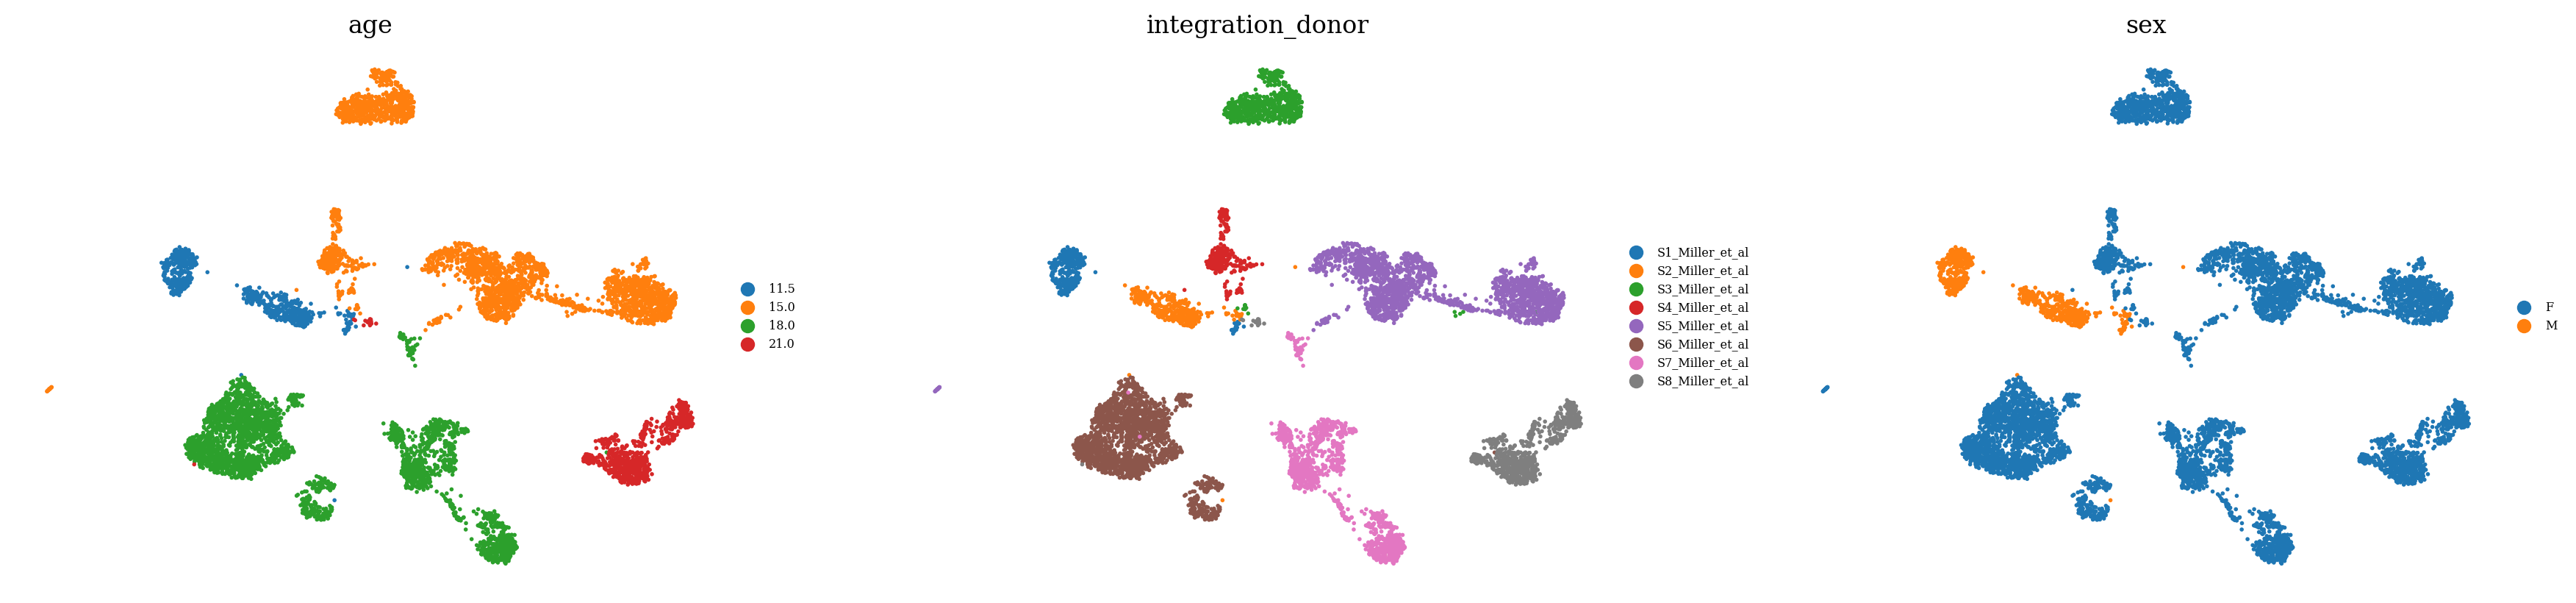

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

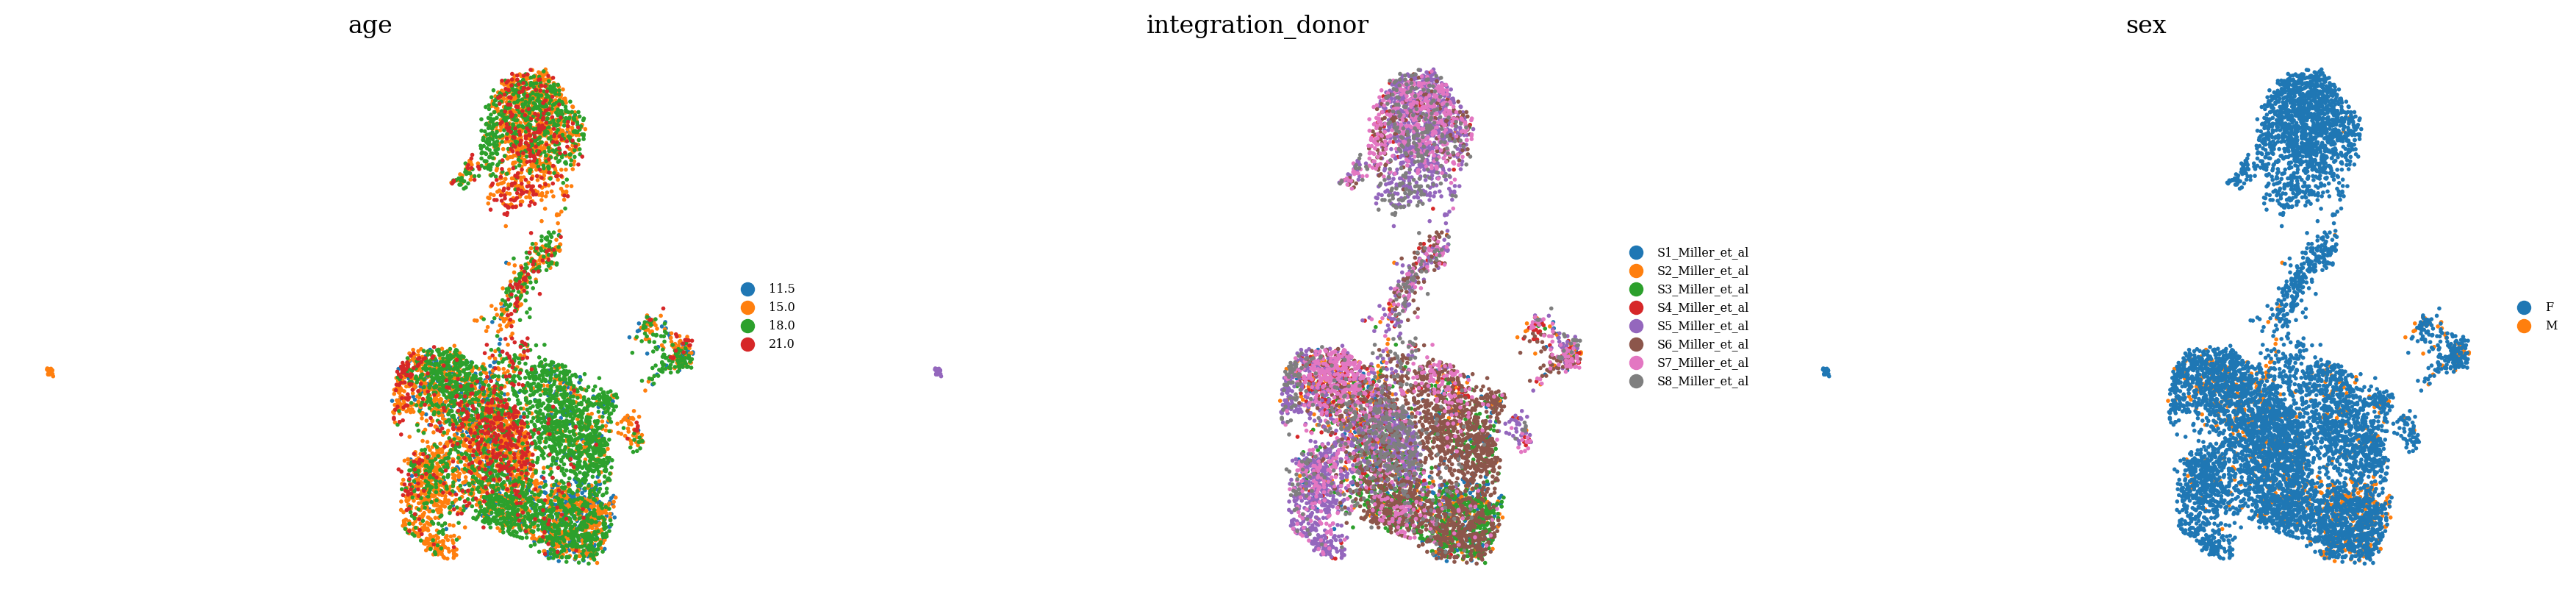

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  6%|▌         | 14/232 [00:00<00:01, 134.40it/s]

 13%|█▎        | 30/232 [00:00<00:01, 145.47it/s]

 19%|█▉        | 45/232 [00:00<00:01, 146.33it/s]

 26%|██▌       | 60/232 [00:00<00:01, 128.38it/s]

 32%|███▏      | 74/232 [00:00<00:01, 119.36it/s]

 38%|███▊      | 87/232 [00:00<00:01, 114.49it/s]

 43%|████▎     | 99/232 [00:00<00:01, 106.73it/s]

 47%|████▋     | 110/232 [00:00<00:01, 106.35it/s]

 52%|█████▏    | 121/232 [00:01<00:01, 105.99it/s]

 57%|█████▋    | 132/232 [00:01<00:00, 105.70it/s]

 62%|██████▏   | 143/232 [00:01<00:00, 105.48it/s]

 66%|██████▋   | 154/232 [00:01<00:00, 105.21it/s]

 71%|███████   | 165/232 [00:01<00:00, 103.91it/s]

 76%|███████▌  | 176/232 [00:01<00:00, 104.23it/s]

 81%|████████  | 187/232 [00:01<00:00, 104.42it/s]

 85%|████████▌ | 198/232 [00:01<00:00, 104.66it/s]

 90%|█████████ | 209/232 [00:01<00:00, 104.86it/s]

 95%|█████████▍| 220/232 [00:01<00:00, 104.35it/s]

100%|█████████▉| 231/232 [00:02<00:00, 104.61it/s]

100%|██████████| 232/232 [00:02<00:00, 109.73it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.39135790757432604

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)